In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/citibike-data-cleaning/__results__.html
/kaggle/input/citibike-data-cleaning/__notebook__.ipynb
/kaggle/input/citibike-data-cleaning/__output__.json
/kaggle/input/citibike-data-cleaning/citibike_cleaned.parquet
/kaggle/input/citibike-data-cleaning/custom.css
/kaggle/input/citibike-data-cleaning/__results___files/__results___36_3.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___25_0.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___26_1.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___35_0.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___36_0.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___36_2.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___36_5.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___36_4.png
/kaggle/input/citibike-data-cleaning/__results___files/__results___27_1.png
/kaggle/input/citibike-data-cleaning/__resu

In [ ]:
! pip install pendulum
! pip install pykalman

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import folium
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
conn = duckdb.connect(
    ':memory:'
)

In [4]:
mibici_rides = pd.read_parquet('/kaggle/input/mibici-data-cleaning/rides-clean.parquet')
mibici_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11963547 entries, 0 to 11968459
Data columns (total 16 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   year_month              string        
 1   trip_id                 int64         
 2   user_id                 int64         
 3   gender                  string        
 4   birth_year              float64       
 5   origin_station_id       int64         
 6   destination_station_id  int64         
 7   trip_started_at         datetime64[ns]
 8   trip_ended_at           datetime64[ns]
 9   trip_duration_seconds   float64       
 10  path_id                 string        
 11  direct_distance_km      float64       
 12  speed_kmh               float64       
 13  day                     int32         
 14  year                    int64         
 15  month                   int64         
dtypes: datetime64[ns](2), float64(4), int32(1), int64(6), string(3)
memory usage: 1.5 GB


In [5]:
mibici_stations = pd.read_parquet('/kaggle/input/mibici-data-cleaning/stations-clean.parquet')
mibici_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          382 non-null    int64  
 1   name        382 non-null    string 
 2   obcn        382 non-null    string 
 3   location    382 non-null    string 
 4   latitude    382 non-null    float64
 5   longitude   382 non-null    float64
 6   in_service  382 non-null    bool   
dtypes: bool(1), float64(2), int64(1), string(3)
memory usage: 18.4 KB


In [ ]:
citibike_rides = pd.read_parquet('/kaggle/input/citibike-data-cleaning/citibike_cleaned.parquet')
citibike_rides.info()

### **Both Mibici and Citibike dataframes are Cleaned**

# **Mibici Business Questions**

# 1) Task 1 = Statistical Summary

## 1-1) Executive Summary

In [ ]:
import pandas as pd
import calendar

# -----------------------------------------------------------------------------
# IMPORTANT: Before running this code, ensure that your 'mibici_rides' DataFrame
# (which contains all MiBici data after cleaning and feature engineering steps)
# is loaded and ready for use in your Python environment/notebook.
# This code assumes the following final columns are present in 'mibici_rides':
# 'trip_id', 'user_id', 'gender', 'birth_year', 'origin_station_id',
# 'destination_station_id', 'trip_started_at', 'trip_ended_at',
# 'trip_duration_seconds', 'path_id', 'direct_distance_km', 'speed_kmh',
# 'day', 'year', 'month'
# -----------------------------------------------------------------------------

# Filter data for the year 2019
df_2019 = mibici_rides[mibici_rides['year'] == 2019].copy()

# Ensure 'trip_started_at' is of datetime type
df_2019['trip_started_at'] = pd.to_datetime(df_2019['trip_started_at'])

# --- Calculate Metrics ---

# 1. Total Rideship
total_rides = df_2019.shape[0]

# 2. Total Unique Users
total_unique_users = df_2019['user_id'].nunique()

# 3. Average Trips per User
average_trips_per_user = total_rides / total_unique_users if total_unique_users > 0 else 0

# 4. Total Ride Time (min)
total_ride_time_min = df_2019['trip_duration_seconds'].sum() / 60

# 5. Average Duration per trip (min)
average_duration_per_trip_min = df_2019['trip_duration_seconds'].mean() / 60

# 6. Median Duration per trip (min)
median_duration_per_trip_min = df_2019['trip_duration_seconds'].median() / 60

# 7. Average Rides per Day
total_active_days = df_2019['trip_started_at'].dt.date.nunique()
average_rides_per_day = total_rides / total_active_days if total_active_days > 0 else 0

# 8. Overall Distance Travelled (km)
overall_distance_travelled_km = df_2019['direct_distance_km'].sum()

# 9. Average Distance per trip (km)
average_distance_per_trip_km = df_2019['direct_distance_km'].mean()

# 10. Average Speed of trips (km/h)
average_speed_kmh = df_2019['speed_kmh'].mean()

# 11. Total Active Stations
total_active_stations = pd.concat([df_2019['origin_station_id'], df_2019['destination_station_id']]).nunique()

# 12. Most Popular Month
most_popular_month_num = df_2019['month'].mode()[0]
most_popular_month_name = calendar.month_name[most_popular_month_num]

# 13. Most Popular Day of Week
most_popular_day_of_week = df_2019['trip_started_at'].dt.day_name().mode()[0]

# 14. Busiest Day of Year
busiest_day_of_year = df_2019['trip_started_at'].dt.date.value_counts().idxmax().strftime('%Y-%m-%d')

# 15. Rush Hour Distribution
def get_time_of_day(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 22:
        return 'Evening'
    else: # 23 and 0 (MiBici operates from 5 AM to 1 AM next day)
        return 'Night'

df_2019['time_of_day'] = df_2019['trip_started_at'].dt.hour.apply(get_time_of_day)
rush_hour_distribution = df_2019['time_of_day'].value_counts(normalize=True) * 100
# Ensure all categories are present, even if their percentage is zero
full_rush_hour_categories = ['Morning', 'Afternoon', 'Evening', 'Night']
rush_hour_distribution = rush_hour_distribution.reindex(full_rush_hour_categories, fill_value=0)


# 16. Max Trips by Single User
max_trips_by_single_user = df_2019['user_id'].value_counts().max()

# 17. Share of Top 10% Active Users
user_trip_counts = df_2019['user_id'].value_counts().sort_values(ascending=False)
num_top_users = int(len(user_trip_counts) * 0.10)
if num_top_users == 0 and len(user_trip_counts) > 0: # If the number of users is less than 10, consider at least 1 top user.
    num_top_users = 1
elif num_top_users == 0 and len(user_trip_counts) == 0: # If no users exist.
    top_10_percent_share = 0
else:
    top_10_percent_trips = user_trip_counts.head(num_top_users).sum()
    top_10_percent_share = (top_10_percent_trips / total_rides) * 100 if total_rides > 0 else 0


# --- Print Results ---
print("Executive Summary Metrics for MiBici Data in 2019:")
print(f"1. Total Rideship: {total_rides}")
print(f"2. Total Unique Users: {total_unique_users}")
print(f"3. Average Trips per User: {average_trips_per_user:.2f}")
print(f"4. Total Ride Time (minutes): {total_ride_time_min:.2f}")
print(f"5. Average Trip Duration (minutes): {average_duration_per_trip_min:.2f}")
print(f"6. Median Trip Duration (minutes): {median_duration_per_trip_min:.2f}")
print(f"7. Average Rides per Day: {average_rides_per_day:.2f}")
print(f"8. Overall Distance Travelled (km): {overall_distance_travelled_km:.2f}")
print(f"9. Average Distance per Trip (km): {average_distance_per_trip_km:.2f}")
print(f"10. Average Speed of Trips (km/h): {average_speed_kmh:.2f}")
print(f"11. Total Active Stations: {total_active_stations}")
print(f"12. Most Popular Month: {most_popular_month_name} (Month {most_popular_month_num})")
print(f"13. Most Popular Day of Week: {most_popular_day_of_week}")
print(f"14. Busiest Day of Year: {busiest_day_of_year}")
print("15. Rush Hour Distribution:")
for time_of_day, percentage in rush_hour_distribution.items():
    print(f"    - {time_of_day}: {percentage:.2f}%")
print(f"16. Max Trips by a Single User: {max_trips_by_single_user}")
print(f"17. Share of Top 10% Active Users: {top_10_percent_share:.2f}%")

## 1-2) User Demographics and Behavior

### Gender Distribution

In [8]:
# محاسبه درصد کاربران منحصربه‌فرد
user_gender_stats = conn.sql("""
    SELECT 
        gender,
        COUNT(DISTINCT user_id) AS unique_users,
        ROUND(COUNT(DISTINCT user_id) * 100.0 / SUM(COUNT(DISTINCT user_id)) OVER (), 2) AS user_percentage
    FROM mibici_rides
    WHERE gender IS NOT NULL
    AND EXTRACT(YEAR FROM trip_started_at) = 2019
    GROUP BY gender
    ORDER BY unique_users DESC
""").fetchdf()

print("🔹 درصد کاربران بر اساس جنسیت:")
print(user_gender_stats)

# محاسبه تعداد و درصد سفرهای انجام‌شده
trip_gender_stats = conn.sql("""
    SELECT 
        gender,
        COUNT(*) AS total_trips,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS trip_percentage
    FROM mibici_rides
    WHERE gender IS NOT NULL
    GROUP BY gender
    ORDER BY total_trips DESC
""").fetchdf()

print("\n🔹 درصد سفرها بر اساس جنسیت:")
print(trip_gender_stats)


🔹 درصد کاربران بر اساس جنسیت:
  gender  unique_users  user_percentage
0      M         19972            64.98
1      F          9426            30.67
2   <NA>          1338             4.35

🔹 درصد سفرها بر اساس جنسیت:
  gender  total_trips  trip_percentage
0      M      8966704            74.95
1      F      2990003            24.99
2   <NA>         6840             0.06


In [ ]:
### **Gender Distribution**

# Query gender distribution by year
result = conn.sql('''
    SELECT 
        LEFT(year_month, 4) AS year, 
        gender, 
        COUNT(*) AS count
    FROM mibici_rides
    WHERE gender IS NOT NULL
    GROUP BY LEFT(year_month, 4), gender
    ORDER BY year, gender;
''').df()

#result = con.execute(result).fetchdf()

# Prepare data for plotting
result = result[result['gender'].isin(['F', 'M'])]
pivot_data = result.pivot(index="year", columns="gender", values="count")



# MiBici color palette: assign custom colors per gender if known
gender_colors = {
    'M': "#55BA51",     # MiBici green
    'F': "#FDC820",   # MiBici yellow
}

# Use available genders in data to select correct colors
used_colors = [gender_colors.get(col.upper(), "#999999") for col in pivot_data.columns]

import matplotlib.ticker as mticker

# Existing plot code
ax = pivot_data.plot(
    kind="bar",
    figsize=(10, 6),
    color=used_colors,
    edgecolor="#444444"
)

# Add data labels to bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",                 
        padding=3,
        fontsize=10,
        color="#333333"
    )

# === Format Y-axis numbers ===
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# MiBici-style formatting
ax.set_title("Gender Distribution Over Time", fontsize=14, weight="bold", loc="left", color="#444444")
ax.set_xlabel("Year", fontsize=14, weight="bold", color="#444444")
ax.set_ylabel("Trip Count", fontsize=14, weight="bold", color="#444444")
ax.tick_params(axis="x", labelsize=12, colors="#444444", rotation=45)
ax.tick_params(axis="y", labelsize=12, colors="#444444")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#444444")
ax.legend(title="Gender", title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.9)

# Save and show
plt.tight_layout()
#plt.savefig("gender_distribution_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### **Gender Distribution**

# Query gender distribution by year
result = conn.sql('''
    SELECT 
        LEFT(year_month, 4) AS year, 
        gender, 
        COUNT(*) AS count
    FROM mibici_rides
    WHERE gender IS NOT NULL
    GROUP BY LEFT(year_month, 4), gender
    ORDER BY year, gender;
''').df()

#result = con.execute(result).fetchdf()

# Prepare data for plotting
result = result[result['gender'].isin(['F', 'M'])]
pivot_data = result.pivot(index="year", columns="gender", values="count")



# MiBici color palette: assign custom colors per gender if known
gender_colors = {
    'M': "#55BA51",     # MiBici green
    'F': "#FDC820",   # MiBici yellow
}

# Use available genders in data to select correct colors
used_colors = [gender_colors.get(col.upper(), "#999999") for col in pivot_data.columns]

import matplotlib.ticker as mticker

# Existing plot code
ax = pivot_data.plot(
    kind="bar",
    figsize=(10, 6),
    color=used_colors,
    edgecolor="#444444"
)

# Add data labels to bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f",                 
        padding=3,
        fontsize=10,
        color="#333333"
    )

# === Format Y-axis numbers ===
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# MiBici-style formatting
ax.set_title("Gender Distribution Over Time", fontsize=14, weight="bold", loc="left", color="#444444")
ax.set_xlabel("Year", fontsize=14, weight="bold", color="#444444")
ax.set_ylabel("Trip Count", fontsize=14, weight="bold", color="#444444")
ax.tick_params(axis="x", labelsize=12, colors="#444444", rotation=45)
ax.tick_params(axis="y", labelsize=12, colors="#444444")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#444444")
ax.legend(title="Gender", title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.9)

# Save and show
plt.tight_layout()
#plt.savefig("gender_distribution_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

### **Age Distribution**

In [ ]:
query_age_filtered = """
    SELECT 
        user_id,
        (year - birth_year) AS age
    FROM mibici_rides
    WHERE birth_year IS NOT NULL 
      AND (year - birth_year) BETWEEN 10 AND 90
"""
age_df = conn.execute(query_age_filtered).fetchdf()


# حذف کاربران تکراری برای گرفتن توزیع سنی یکتا
unique_users = age_df.drop_duplicates(subset='user_id')

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram plot
ax.hist(
    unique_users['age'],
    bins=20,
    color="#55BA51",
    linewidth=1,
    edgecolor='darkgray'
)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
# Add mean line
ax.axvline(unique_users["age"].mean(), color="#FDC820", linewidth=3, linestyle="--", label="Mean Age")
ax.axvline(unique_users["age"].median(), color="red", linewidth=3, linestyle="--", label="Median Age")

# Set chart title and labels
ax.set_title("Age Distribution of Unique Users", fontsize=14, weight="bold", loc="left", color="#444444")
ax.set_xlabel("Age", fontsize=14, weight="bold", loc="left", color="#444444")
ax.set_ylabel("Number of Users", fontsize=14, weight="bold", color="#444444")

# Ticks and borders
ax.tick_params(axis="x", labelsize='large', colors="#444444")
ax.tick_params(axis="y", labelsize='large', colors="#444444")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#444444")
#ax.grid(axis='y', linestyle="--", color="#444444")

# Legend and save
ax.legend()
#plt.savefig("age_distribution_unique_users.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

user_births = """
    SELECT birth_year FROM mibici_rides WHERE birth_year is not null
"""
user_births = conn.execute(user_births).fetchdf()


plt.figure(figsize=(10, 6))

# Plot histogram with MiBici main green and styled borders
plt.hist(
    user_births['birth_year'],
    bins=30,
    color="#55BA51",            # MiBici green
    edgecolor="#333333",        # Border color
    linewidth=1
)
# Apply MiBici style
plt.title('Distribution of Birth Year (Unique Users Only)', fontsize=14, weight='bold', loc='left', color='#333333')
plt.xlabel('Birth Year', fontsize=14, weight='bold', loc='left', color='#333333')
plt.ylabel('Number of Users', fontsize=14, weight='bold', color='#333333')

plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
#plt.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Remove top/right borders, keep left/bottom in dark gray
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")

# Save and show
plt.tight_layout()
#plt.savefig("birth_year_distribution_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

### Proportion of Unique Users by age Group overtime

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

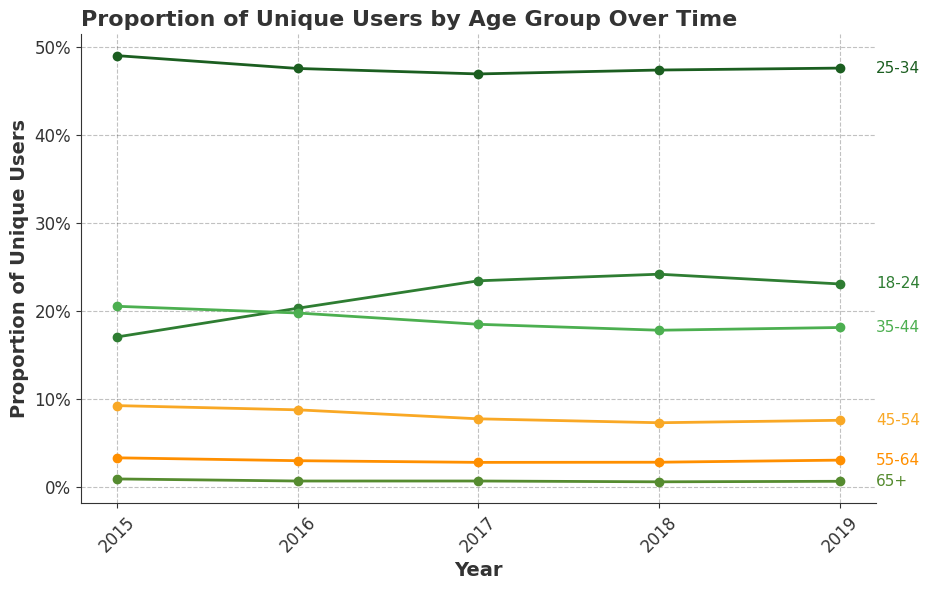

In [10]:
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator  # اضافه کردن MaxNLocator

# کوئری استخراج داده‌های سن کاربران
sql_query_age_distribution = """
SELECT
    CAST(LEFT(year_month, 4) AS INTEGER) AS year,
    CASE
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year BETWEEN 18 AND 24 THEN '18-24'
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year BETWEEN 25 AND 34 THEN '25-34'
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year BETWEEN 35 AND 44 THEN '35-44'
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year BETWEEN 45 AND 54 THEN '45-54'
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year BETWEEN 55 AND 64 THEN '55-64'
        WHEN CAST(LEFT(year_month, 4) AS INTEGER) - birth_year >= 65 THEN '65+'
        ELSE 'Unknown'
    END AS age_group,
    COUNT(DISTINCT user_id) AS unique_users
FROM mibici_rides
WHERE birth_year IS NOT NULL 
  AND (CAST(LEFT(year_month, 4) AS INTEGER) - birth_year) >= 18
GROUP BY LEFT(year_month, 4), age_group
ORDER BY year, age_group
"""

# اجرای کوئری و ساخت دیتافریم
result = conn.execute(sql_query_age_distribution).fetchdf()

# تعریف ترتیب گروه‌های سنی
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Pivot و نرمال‌سازی داده‌ها
pivot_data = result.pivot(index="year", columns="age_group", values="unique_users")
pivot_data = pivot_data.reindex(columns=age_group_order, fill_value=0)
normalized_pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0)

# تنظیم رنگ‌ها
colors = [
    "#2E7D32",  # Dark Green (instead of #55BA51)
    "#1B5E20",  # Very Dark Green (instead of #3E9842)
    "#4CAF50",  # Deep MiBici Green (instead of #A5D6A7)
    "#F9A825",  # Strong Yellow-Orange (instead of #FDC820)
    "#FF8F00",  # Darker Orange-Yellow (instead of #F5B400)
    "#558B2F"   # Olive Green (instead of #7DBE64)
]

label_color = "#333333"

# رسم نمودار
fig, ax = plt.subplots(figsize=(10, 6))

for i, group in enumerate(age_group_order):
    ax.plot(
        normalized_pivot_data.index,
        normalized_pivot_data[group],
        label=group,
        color=colors[i],
        marker='o',
        linewidth=2
    )
    
    # افزودن لیبل در کنار هر خط
    ax.text(
        x=normalized_pivot_data.index[-1] + 0.2,
        y=normalized_pivot_data[group].values[-1],
        s=group,
        fontsize=11,
        color=colors[i],
        va='center'
    )

# تنظیمات ظاهری
ax.set_title("Proportion of Unique Users by Age Group Over Time", fontsize=16, fontweight='bold', loc='left', color=label_color)
ax.set_xlabel("Year", fontsize=14, weight="bold", color=label_color)
ax.set_ylabel("Proportion of Unique Users", fontsize=14, weight="bold", color=label_color)
ax.tick_params(axis='x', labelsize=12, colors=label_color, rotation=45)
ax.tick_params(axis='y', labelsize=12, colors=label_color)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color(label_color)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.grid(True, linestyle='--', color=label_color, alpha=0.3)

# جلوگیری از نمایش اعداد اعشاری در محور X
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# حذف legend چون لیبل‌ها درج شده‌اند
ax.legend().set_visible(False)

# تنظیم برای فضای سمت راست لیبل‌ها
plt.tight_layout(rect=[0, 0, 0.94, 1])
#plt.savefig("age_group_distribution_mibici.png", dpi=300, bbox_inches='tight')
plt.show()


### **Annual Growth unique Users**

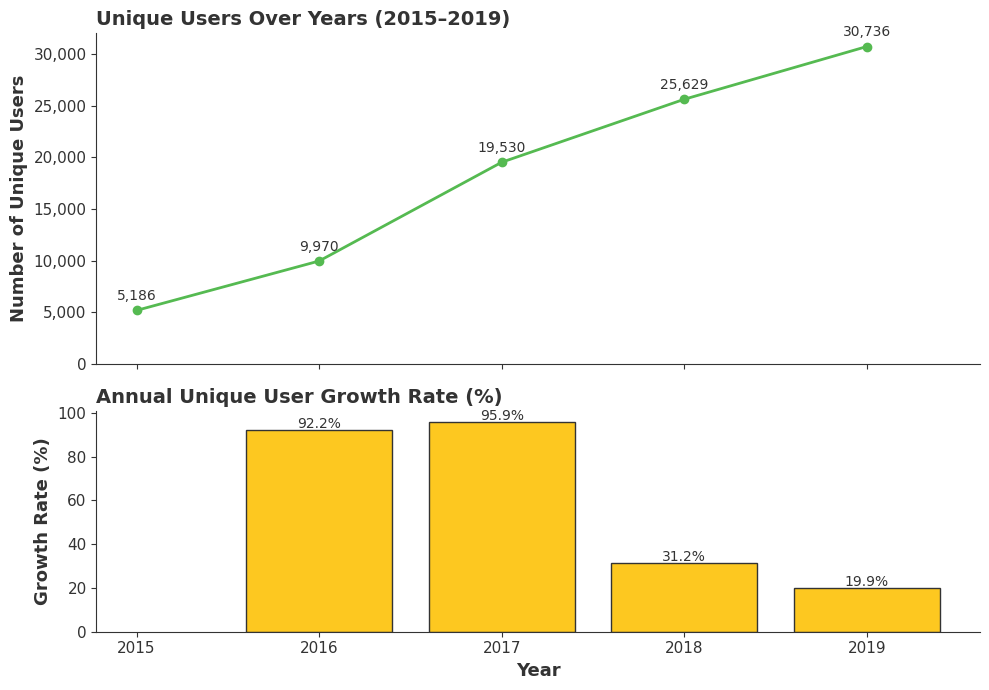

In [14]:
import matplotlib.ticker as mtick  # اصلاح اینجا

# Query unique users per year
sql_query_unique_users_per_year = """
SELECT
    year,
    COUNT(DISTINCT user_id) AS unique_users
FROM
    mibici_rides
WHERE
    year BETWEEN 2015 AND 2019
GROUP BY
    year
ORDER BY
    year
"""
result = conn.execute(sql_query_unique_users_per_year).fetchdf()
result['year'] = result['year'].astype(int)
result['growth_rate'] = result['unique_users'].pct_change() * 100

# --- MiBici Style ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# MiBici colors
green = '#55BA51'
yellow = '#FDC820'
gray = '#333333'

ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# --- Top: Line plot for unique users ---
ax1.plot(result['year'], result['unique_users'], marker='o', color=green, linewidth=2, label="Unique Users")

# Annotate data points
for x, y in zip(result['year'], result['unique_users']):
    ax1.text(x, y + 1000, f"{y:,}", ha='center', fontsize=10, color=gray)

# تنظیم محدوده محور Y برای شروع از صفر
ax1.set_ylim(bottom=0)

ax1.set_title("Unique Users Over Years (2015–2019)", fontsize=14, weight="bold", loc="left", color=gray)
ax1.set_ylabel("Number of Unique Users", fontsize=13, weight="bold", color=gray)
ax1.tick_params(axis='x', labelsize=11, colors=gray)
ax1.tick_params(axis='y', labelsize=11, colors=gray)
ax1.spines[["top", "right"]].set_visible(False)
ax1.spines[["bottom", "left"]].set_color(gray)

# --- Bottom: Bar plot for growth rate ---
bars = ax2.bar(result['year'], result['growth_rate'], color=yellow, edgecolor=gray)

# Annotate bars
for bar in bars:
    if not pd.isna(bar.get_height()):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.1f}%", ha='center', fontsize=10, color=gray)

ax2.set_title("Annual Unique User Growth Rate (%)", fontsize=14, weight="bold", loc="left", color=gray)
ax2.set_ylabel("Growth Rate (%)", fontsize=13, weight="bold", color=gray)
ax2.set_xlabel("Year", fontsize=13, weight="bold", color=gray)
ax2.tick_params(axis='x', labelsize=11, colors=gray)
ax2.tick_params(axis='y', labelsize=11, colors=gray)
ax2.spines[["top", "right"]].set_visible(False)
ax2.spines[["bottom", "left"]].set_color(gray)

# Finalize
plt.tight_layout()
#plt.savefig("unique_user_growth_rate_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

## 1-3) Duration and Distance Trend

### Trip Duration Histogram

In [ ]:
# محاسبه مدت زمان سفر به دقیقه (فقط سفرهای معتبر)
query = """
    SELECT trip_duration_seconds / 60.0 AS duration_min
    FROM mibici_rides
    WHERE trip_duration_seconds > 0 AND trip_duration_seconds <= 3600
"""
duration_df = conn.execute(query).fetchdf()

fig, ax = plt.subplots(figsize=(10, 6))

# رسم هیستوگرام
ax.hist(
    duration_df["duration_min"],
    bins=50,
    color="#55BA51",         # MiBici green
    edgecolor="#333333",
    linewidth=1
)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# سبک MiBici برای عنوان و برچسب‌ها
ax.set_title("Distribution of Trip Duration (in Minutes)", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_xlabel("Trip Duration (minutes)", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_ylabel("Number of Trips", fontsize=14, weight="bold", color="#333333")

# تنظیمات ظاهری محورها و چارچوب
ax.tick_params(axis="x", labelsize=12, colors="#333333")
ax.tick_params(axis="y", labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle="--", color="#333333", alpha=0.3)

# ذخیره و نمایش نمودار
plt.tight_layout()
#plt.savefig("trip_duration_distribution_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

### Total Rideships Per year

In [ ]:

# Step 1: Query total trips by year
result = conn.sql('''
    SELECT 
        LEFT(year_month, 4) AS year,
        COUNT(*) AS total_trips
    FROM mibici_rides
    WHERE LEFT(year_month, 4) BETWEEN '2015' AND '2019'
    GROUP BY LEFT(year_month, 4)
    ORDER BY year
''').df()

# Convert year to int for plotting
result["year"] = result["year"].astype(int)

# Step 2: Compute growth rate
result["growth_rate"] = result["total_trips"].pct_change() * 100

# Step 3: Plot dual-subplot with MiBici styling
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

## 🔹 Top plot: Line chart for total trips
ax1.plot(
    result["year"],
    result["total_trips"],
    marker='o',
    color="#55BA51",
    linewidth=2,
    label="Total Trips"
)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))


# Annotate values on the line
for x, y in zip(result["year"], result["total_trips"]):
    ax1.text(
        x, y + 50000,
        f"{y:,}",
        ha='center',
        fontsize=10,
        color="#333333"
    )

ax1.set_title("Total Trips & Yearly Growth Rate (2015–2019)", fontsize=14, weight="bold", loc="left", color="#333333")
ax1.set_ylabel("Total Trips", fontsize=13, weight="bold", color="#333333")
ax1.tick_params(axis="y", labelsize=12, colors="#333333")
ax1.spines[["top", "right"]].set_visible(False)
ax1.spines[["bottom", "left"]].set_color("#333333")

## 🔸 Bottom plot: Bar chart for growth rate
bars2 = ax2.bar(
    result["year"],
    result["growth_rate"],
    color="#FDC820",
    edgecolor="#333333"
)

# Annotate percentages
for bar in bars2:
    height = bar.get_height()
    if pd.notnull(height):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f"{height:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            color="#333333"
        )
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax2.set_xlabel("Year", fontsize=13, weight="bold", color="#333333")
ax2.set_ylabel("Growth Rate (%)", fontsize=13, weight="bold", color="#333333")
ax2.tick_params(axis="x", labelsize=12, colors="#333333")
ax2.tick_params(axis="y", labelsize=12, colors="#333333")
ax2.spines[["top", "right"]].set_visible(False)
ax2.spines[["bottom", "left"]].set_color("#333333")
#ax2.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)

# Finalize layout
plt.tight_layout()
#plt.savefig("total_trips_growth_mibici_combined.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Query total trips by year
result = conn.sql('''
    SELECT 
        LEFT(year_month, 4) AS year,
        COUNT(*) AS total_trips
    FROM mibici_rides
    WHERE LEFT(year_month, 4) BETWEEN '2015' AND '2019'
    GROUP BY LEFT(year_month, 4)
    ORDER BY year;
''').df()

# Plot with MiBici style
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    result['year'],
    result['total_trips'],
    color="#55BA51",         # MiBici Green
    edgecolor="#333333"
)

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 50000,  # adjust this offset based on your scale
        f"{height:,}",
        ha='center',
        va='bottom',
        fontsize=10,
        color="#333333"
    )

# Apply MiBici styling
ax.set_title("Total Rideships (2015–2019)", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_xlabel("Year", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_ylabel("Total Trips", fontsize=14, weight="bold", color="#333333")

ax.tick_params(axis="x", labelsize=12, colors="#333333", rotation=45)
ax.tick_params(axis="y", labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
#ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)

# Finalize
plt.tight_layout()
#plt.savefig("total_trips_mibici.png", dpi=300, bbox_inches='tight')
plt.show()


### Average Distance (km) in age groups

In [ ]:

# Compute average direct distance per age using DuckDB
query_avg_distance_by_age = """
SELECT
    year - birth_year AS age,
    AVG(direct_distance_km) AS avg_distance
FROM mibici_rides
WHERE birth_year IS NOT NULL
  AND year - birth_year BETWEEN 15 AND 80
GROUP BY age
ORDER BY age
"""

# Execute the query and fetch as a pandas DataFrame
avg_distance_by_age = conn.execute(query_avg_distance_by_age).fetchdf()

# --- Plot with MiBici style ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line
ax.plot(
    avg_distance_by_age['age'],
    avg_distance_by_age['avg_distance'],
    color="#55BA51",  # MiBici green
    linewidth=2,
    marker='o',
    label="Average Distance"
)

# Optional: add mean line (overall mean)
overall_mean_query = "SELECT AVG(direct_distance_km) FROM mibici_rides WHERE birth_year IS NOT NULL"
overall_mean = conn.execute(overall_mean_query).fetchone()[0]
ax.axhline(overall_mean, color="#FDC820", linestyle="--", linewidth=2, label="Overall Mean")

# Apply MiBici style formatting
ax.set_title("Average Trip Distance by Age", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_xlabel("Age", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_ylabel("Average Distance (km)", fontsize=14, weight="bold", color="#333333")
ax.tick_params(axis="x", labelsize='large', colors="#333333")
ax.tick_params(axis="y", labelsize='large', colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle="--", color="#333333", alpha=0.3)
ax.legend()

# Finalize
plt.tight_layout()
#plt.savefig("avg_trip_distance_by_age_duckdb.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# DuckDB query to count total trips per age
query_total_trips_by_age = """
SELECT
    year - birth_year AS age,
    COUNT(*) AS total_trips
FROM mibici_rides
WHERE birth_year IS NOT NULL
  AND year - birth_year BETWEEN 15 AND 80
GROUP BY age
ORDER BY age
"""

# Execute and load into DataFrame
total_trips_by_age = conn.execute(query_total_trips_by_age).fetchdf()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line chart for total trips
ax.plot(
    total_trips_by_age['age'],
    total_trips_by_age['total_trips'],
    color="#55BA51",  # MiBici green
    linewidth=2,
    marker='o',
    label="Total Trips"
)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Optional mean line (for large scales, usually not used here)
mean_trips = total_trips_by_age['total_trips'].mean()
ax.axhline(mean_trips, color="#FDC820", linestyle="--", linewidth=2, label="Average")

# Apply MiBici style
ax.set_title("Total Trips by Age", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_xlabel("Age", fontsize=14, weight="bold", loc="left", color="#333333")
ax.set_ylabel("Total Trips", fontsize=14, weight="bold", color="#333333")
ax.tick_params(axis="x", labelsize='large', colors="#333333")
ax.tick_params(axis="y", labelsize='large', colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle="--", color="#333333", alpha=0.3)
ax.legend()

# Finalize and save
plt.tight_layout()
#plt.savefig("total_trips_by_age_mibici.png", dpi=300, bbox_inches='tight')
plt.show()

## 1-4) Temporal Trends (Hour, Week, Month)

### Hourly and Weekly Trend

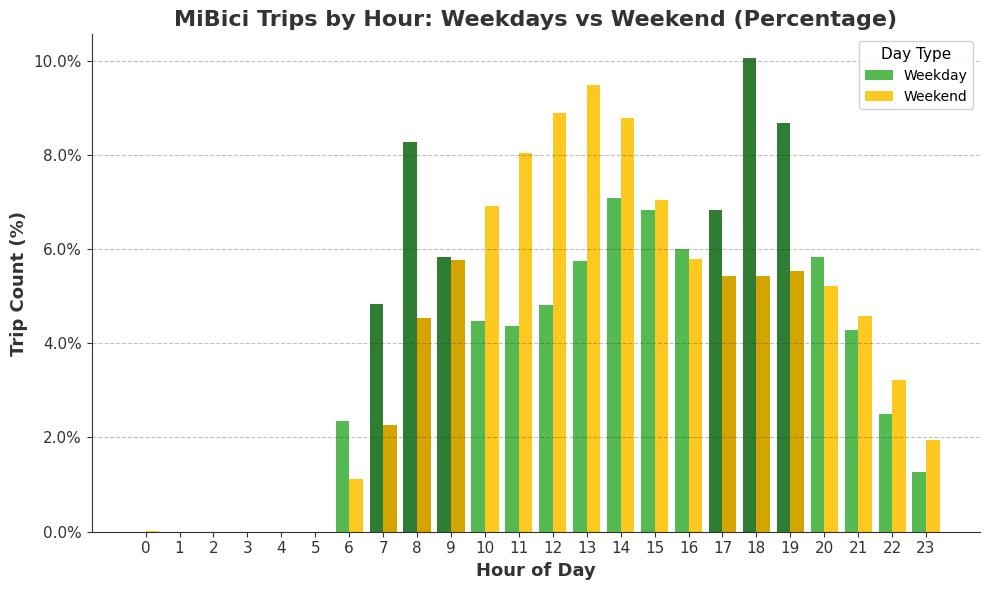

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# SQL query to fetch the data
sql = """
SELECT 
    EXTRACT(HOUR FROM trip_started_at) AS hour,
    CASE 
        WHEN EXTRACT(DOW FROM trip_started_at) IN (0, 6) THEN 'Weekend'
        ELSE 'Weekday'
    END AS day_type,
    COUNT(*) AS trip_count
FROM mibici_rides
WHERE trip_started_at IS NOT NULL
GROUP BY hour, day_type
ORDER BY hour, day_type
"""
hourly_trips = conn.execute(sql).fetchdf()

# Pivot to have one column for each day_type
pivot_df = hourly_trips.pivot(index='hour', columns='day_type', values='trip_count').fillna(0)

# Ensure hours are sorted correctly
pivot_df = pivot_df.sort_index()

# Calculate total trips for each day type (Weekday and Weekend)
total_weekday_trips = pivot_df['Weekday'].sum()
total_weekend_trips = pivot_df['Weekend'].sum()

# Convert trip counts to percentages
pivot_df['Weekday'] = pivot_df['Weekday'] / total_weekday_trips * 100
pivot_df['Weekend'] = pivot_df['Weekend'] / total_weekend_trips * 100

# Define rush hours for color highlighting
rush_hours = list(range(7, 10)) + list(range(17, 20))

colors_weekday = ['#55BA51' if h not in rush_hours else '#2E7D32' for h in pivot_df.index]
colors_weekend = ['#FDC820' if h not in rush_hours else '#D4A500' for h in pivot_df.index]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
x = pivot_df.index

# Format y-axis to show percentages
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:.1f}%"))

# Plot with custom colors
ax.bar(x - bar_width/2, pivot_df['Weekday'], width=bar_width, label='Weekday', color=colors_weekday)
ax.bar(x + bar_width/2, pivot_df['Weekend'], width=bar_width, label='Weekend', color=colors_weekend)

# Add labels and styles
ax.set_title("MiBici Trips by Hour: Weekdays vs Weekend (Percentage)", fontsize=16, weight="bold", color="#333333")
ax.set_xlabel("Hour of Day", fontsize=13, weight="bold", color="#333333")
ax.set_ylabel("Trip Count (%)", fontsize=13, weight="bold", color="#333333")
ax.tick_params(axis='both', labelsize=11, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.set_xticks(range(0, 24))
ax.legend(title="Day Type", title_fontsize=11, fontsize=10, framealpha=0.9)
ax.grid(axis='y', linestyle='--', alpha=0.3, color="#333333")

plt.tight_layout()
#plt.savefig("mibici_hourly_trips_percentage.png", dpi=300)
plt.show()


### Daily 

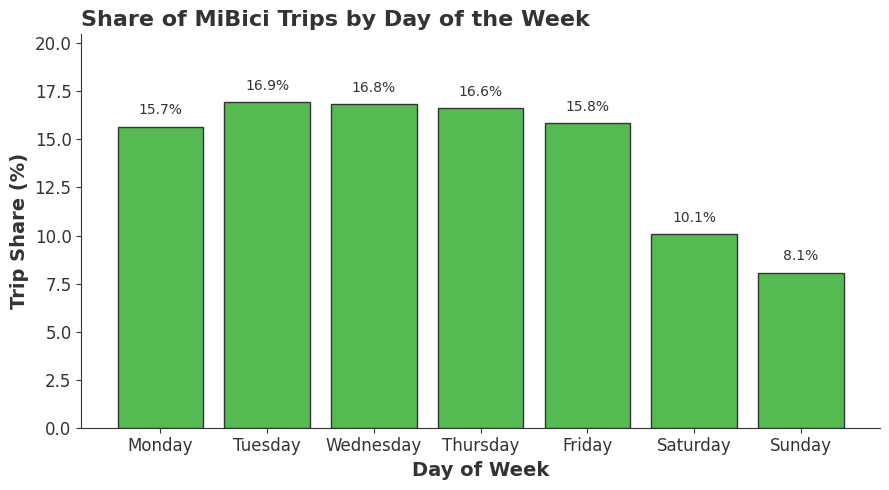

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Query trips by day of week
query = """
SELECT 
    EXTRACT(DOW FROM trip_started_at) AS dow,  
    COUNT(*) AS trip_count
FROM mibici_rides
WHERE trip_started_at IS NOT NULL
GROUP BY dow
ORDER BY dow
"""
dow_df = conn.execute(query).fetchdf()

# Step 2: Map day numbers to names
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
dow_df['day'] = dow_df['dow'].astype(int).map(dict(zip(range(7), day_labels)))

# Step 3: Reorder the days to start from Monday
dow_df['day'] = dow_df['day'].replace({
    'Sunday': '7',
    'Monday': '1',
    'Tuesday': '2',
    'Wednesday': '3',
    'Thursday': '4',
    'Friday': '5',
    'Saturday': '6'
})

# Step 4: Sort the days to start from Monday
dow_df['day'] = pd.Categorical(dow_df['day'], categories=['1', '2', '3', '4', '5', '6', '7'], ordered=True)
dow_df = dow_df.sort_values('day')

# Step 5: Map days back to labels
dow_df['day'] = dow_df['day'].map({
    '1': 'Monday',
    '2': 'Tuesday',
    '3': 'Wednesday',
    '4': 'Thursday',
    '5': 'Friday',
    '6': 'Saturday',
    '7': 'Sunday'
})

# Step 6: Compute percentages
dow_df['trip_percentage'] = dow_df['trip_count'] / dow_df['trip_count'].sum() * 100

# Step 7: Plot
fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(
    dow_df['day'],
    dow_df['trip_percentage'],
    color="#55BA51",
    edgecolor="#333333"
)

# Add data labels (percentage text on top)
for bar, pct in zip(bars, dow_df['trip_percentage']):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.5,
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color="#333333"
    )

# MiBici style
ax.set_title("Share of MiBici Trips by Day of the Week", fontsize=16, weight="bold", loc="left", color="#333333")
ax.set_xlabel("Day of Week", fontsize=14, weight="bold", color="#333333")
ax.set_ylabel("Trip Share (%)", fontsize=14, weight="bold", color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.tick_params(axis='y', labelsize=12, colors="#333333")
ax.set_ylim(0, dow_df['trip_percentage'].max() * 1.15 + 1)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
#ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)

# Finalize
plt.tight_layout()
#plt.savefig("mibici_weekday_trip_share.png", dpi=300, bbox_inches='tight')
plt.show()


### Monthly

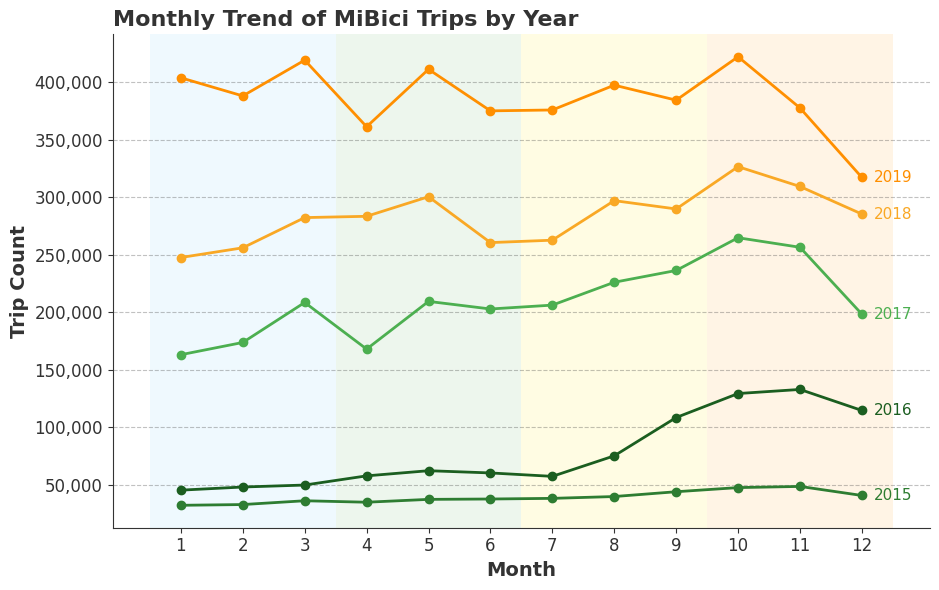

In [17]:
# 1. SQL Query: Monthly trip counts grouped by year and month
query = """
SELECT 
    EXTRACT(YEAR FROM trip_started_at) AS year,
    EXTRACT(MONTH FROM trip_started_at) AS month,
    COUNT(*) AS total_trips
FROM mibici_rides
WHERE trip_started_at IS NOT NULL
GROUP BY EXTRACT(YEAR FROM trip_started_at), EXTRACT(MONTH FROM trip_started_at)
ORDER BY year, month
"""
monthly_trips = conn.execute(query).fetchdf()

# 2. Pivot data: one line per year
pivot_df = monthly_trips.pivot(index='month', columns='year', values='total_trips').fillna(0)
pivot_df = pivot_df.sort_index()

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 6))

# MiBici color palette
#colors = ['#F5B400', '#FDC820', '#A5D6A7', '#3E9842', '#55BA51']
colors = [
    "#2E7D32",  # Dark Green (instead of #55BA51)
    "#1B5E20",  # Very Dark Green (instead of #3E9842)
    "#4CAF50",  # Deep MiBici Green (instead of #A5D6A7)
    "#F9A825",  # Strong Yellow-Orange (instead of #FDC820)
    "#FF8F00",  # Darker Orange-Yellow (instead of #F5B400)
    "#558B2F"   # Olive Green (instead of #7DBE64)
]
label_color = '#333333'

# 4. Draw each year line + add text label at end
for i, year in enumerate(pivot_df.columns):
    ax.plot(
        pivot_df.index,
        pivot_df[year],
        marker='o',
        linewidth=2,
        color=colors[i % len(colors)]
    )
    
    # Add year label at last month value
    ax.text(
        x=12.2,
        y=pivot_df.loc[12, year],
        s=str(int(year)),
        fontsize=11,
        color=colors[i % len(colors)],
        va='center'
    )
# قبل از رسم خطوط، ابتدا رنگ‌ پس‌زمینه‌ی فصل‌ها را اضافه کن:
# رنگ‌های تقویت‌شده برای هر فصل
season_colors = {
    "Winter": "#B3E5FC",   # blue - زمستان
    "Spring": "#A5D6A7",   # green - بهار
    "Summer": "#FFF176",   # yellow - تابستان
    "Autumn": "#FFCC80"    # orange - پاییز
}
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# نمایش پس‌زمینه فصل‌ها
ax.axvspan(0.5, 3.5, facecolor=season_colors["Winter"], alpha=0.2)
ax.axvspan(3.5, 6.5, facecolor=season_colors["Spring"], alpha=0.2)
ax.axvspan(6.5, 9.5, facecolor=season_colors["Summer"], alpha=0.2)
ax.axvspan(9.5, 12.5, facecolor=season_colors["Autumn"], alpha=0.2)


# 5. MiBici style
ax.set_title("Monthly Trend of MiBici Trips by Year", fontsize=16, weight='bold', loc='left', color=label_color)
ax.set_xlabel("Month", fontsize=14, weight='bold', color=label_color)
ax.set_ylabel("Trip Count", fontsize=14, weight='bold', color=label_color)
ax.tick_params(axis='x', labelsize=12, colors=label_color)
ax.tick_params(axis='y', labelsize=12, colors=label_color)
ax.set_xticks(range(1, 13))
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color(label_color)
ax.grid(axis='y', linestyle='--', color=label_color, alpha=0.3)

# حذف legend چون سال‌ها روی خطوط نوشته شده‌اند
ax.legend().set_visible(False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])
#plt.savefig("monthly_trend_by_year_inline_labels.png", dpi=300, bbox_inches='tight')
plt.show()


## 1-5) Stations and Traffic Overflow

### All Stations on the Map

In [ ]:
import folium

# Load station data
stations_df = "SELECT * FROM mibici_stations"

# اجرا و دریافت داده‌ها
stations_df = conn.execute(stations_df).fetchdf()


# Define map center
map_center = [stations_df['latitude'].mean(), stations_df['longitude'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# MiBici color
mibici_green = "red"

# Add station markers with MiBici style
for _, row in stations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=folium.Popup(row['id'], parse_html=True),
        color=mibici_green,         # Border color
        fill=True,
        fill_color=mibici_green,    # Fill color
        fill_opacity=0.8
    ).add_to(station_map)
import folium

# Load station data
stations_df = "SELECT * FROM mibici_stations"

# اجرا و دریافت داده‌ها
stations_df = conn.execute(stations_df).fetchdf()


# Define map center
map_center = [stations_df['latitude'].mean(), stations_df['longitude'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# MiBici color
mibici_green = "red"

# Add station markers with MiBici style
for _, row in stations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=folium.Popup(row['id'], parse_html=True),
        color=mibici_green,         # Border color
        fill=True,
        fill_color=mibici_green,    # Fill color
        fill_opacity=0.8
    ).add_to(station_map)

station_map.save("mibici_station_map.html")
station_map


### Top and Bottom Destinations and Origins 

In [ ]:
# 5 ایستگاه پرتردد مبدأ
top_origins = conn.execute("""
    SELECT origin_station_id AS station_id, COUNT(*) AS trip_count
    FROM mibici_rides
    GROUP BY origin_station_id
    ORDER BY trip_count DESC
    LIMIT 5
""").fetchdf()

# 10 ایستگاه پرتردد مقصد
top_destinations = conn.execute("""
    SELECT destination_station_id AS station_id, COUNT(*) AS trip_count
    FROM mibici_rides
    GROUP BY destination_station_id
    ORDER BY trip_count DESC
    LIMIT 5
""").fetchdf()

# الحاق با اطلاعات نام ایستگاه (در صورت نیاز)
stations_df = conn.execute("SELECT id, name FROM mibici_stations").fetchdf()
top_origins = top_origins.merge(stations_df, left_on="station_id", right_on="id")
top_destinations = top_destinations.merge(stations_df, left_on="station_id", right_on="id")
top_destinations

In [ ]:
from matplotlib.ticker import FuncFormatter

# مرتب‌سازی از بیشترین به کمترین و معکوس کردن برای barh
top_origins_sorted = top_origins.sort_values(by="trip_count", ascending=False).iloc[::-1]

# رنگ‌ها
origin_colors = ['#CCCCCC'] * len(top_origins_sorted)
origin_colors[-1] = '#55BA51'
origin_colors[-2] = '#FDC820'
origin_colors[-3] = '#FDC820'

# رسم نمودار
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(
    top_origins_sorted["name"],
    top_origins_sorted["trip_count"],
    color=origin_colors,
    edgecolor="#333333"
)

# افزودن برچسب عددی
for bar in bars:
    width = bar.get_width()
    ax.text(width + 500, bar.get_y() + bar.get_height() / 2, f"{int(width):,}", 
            va='center', fontsize=10, color="#333333")

# استایل
ax.set_title("Top 5 MiBici Origin Stations", fontsize=16, weight='bold', loc="left", color="#333333")
ax.set_xlabel("Number of Trips", fontsize=14, weight='bold', color="#333333")
ax.set_ylabel("Station", fontsize=14, weight='bold', color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.tick_params(axis='y', labelsize=12, colors="#333333")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))  # 🔷 اضافه کردن این خط
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='x', linestyle='--', color="#333333", alpha=0.3)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.ticker import FuncFormatter

# مرتب‌سازی از بیشترین به کمترین و سپس معکوس برای نمایش از بالا به پایین
top_destinations_sorted = top_destinations.sort_values(by="trip_count", ascending=False).iloc[::-1]

# تنظیم رنگ‌ها: اول = سبز، دوم و سوم = زرد، بقیه = خاکستری
dest_colors = ['#CCCCCC'] * len(top_destinations_sorted)
dest_colors[-1] = '#55BA51'  # ایستگاه اول (پر استفاده‌ترین)
dest_colors[-2] = '#FDC820'  # دوم
dest_colors[-3] = '#FDC820'  # سوم

# رسم نمودار
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(
    top_destinations_sorted["name"],
    top_destinations_sorted["trip_count"],
    color=dest_colors,
    edgecolor="#333333"
)

# افزودن برچسب عددی در کنار میله‌ها
for bar in bars:
    width = bar.get_width()
    ax.text(width + 500, bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}", va='center', fontsize=10, color="#333333")

# استایل
ax.set_title("Top 5 MiBici Destination Stations", fontsize=16, weight='bold', loc="left", color="#333333")
ax.set_xlabel("Number of Trips", fontsize=14, weight='bold', color="#333333")
ax.set_ylabel("Station", fontsize=14, weight='bold', color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.tick_params(axis='y', labelsize=12, colors="#333333")

# جداکننده سه‌رقمی برای محور x
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# سایر تنظیمات ظاهری
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='x', linestyle='--', color="#333333", alpha=0.3)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()


###  Most Popular Routes

In [ ]:
# Extract the most traveled paths in 2019 (excluding round-trips)
result = conn.sql('''
    SELECT  
        path_id,
        origin_station_id,
        destination_station_id,
        COUNT(*) AS total_trips
    FROM mibici_rides
    WHERE LEFT(year_month, 4) = '2019'
    AND origin_station_id <> destination_station_id  -- Exclude same-station paths
    GROUP BY path_id, origin_station_id, destination_station_id
    ORDER BY total_trips DESC
    LIMIT 20;
''').df()

# Extract the **top 10 round-trip paths** (where riders start & end at the same station)
round_trip_paths = conn.sql('''
    SELECT  
        path_id,
        origin_station_id,
        destination_station_id,
        COUNT(*) AS total_trips
    FROM mibici_rides
    WHERE LEFT(year_month, 4) = '2019'
    AND origin_station_id = destination_station_id  -- Only same-station trips
    GROUP BY path_id, origin_station_id, destination_station_id
    ORDER BY total_trips DESC
    LIMIT 10;
''').df()

# Load station locations (latitude, longitude)
stations = conn.sql('''
    SELECT id AS station_id, latitude, longitude
    FROM mibici_stations;
''').df()

# Merge station coordinates for origin & destination stations in main dataset
result = result.merge(stations.rename(columns={'station_id': 'origin_station_id', 'latitude': 'latitude_origin', 'longitude': 'longitude_origin'}), 
                      on='origin_station_id', how='left')

result = result.merge(stations.rename(columns={'station_id': 'destination_station_id', 'latitude': 'latitude_destination', 'longitude': 'longitude_destination'}), 
                      on='destination_station_id', how='left')

# Merge station coordinates for round-trip stations
round_trip_paths = round_trip_paths.merge(stations.rename(columns={'station_id': 'origin_station_id', 'latitude': 'latitude_origin', 'longitude': 'longitude_origin'}), 
                                          on='origin_station_id', how='left')

# Identify stations in different categories
top_origin_stations = set(result['origin_station_id'])
top_destination_stations = set(result['destination_station_id'])
purple_stations = top_origin_stations & top_destination_stations  # Stations appearing as both origin & destination
pink_stations = set(round_trip_paths['origin_station_id'])  # Stations involved in round-trip paths

from folium.plugins import AntPath

# مرکز نقشه
map_center = [stations['latitude'].mean(), stations['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14, tiles="CartoDB positron")

# تعریف رنگ‌ها
colors = {
    'origin': "#3399FF",       # آبی برای مبدأ
    'destination': "#FF3333",  # قرمز برای مقصد
    'both': "#9933FF",         # بنفش برای هر دو
    'round_trip': "#FF66CC",   # صورتی برای ایستگاه‌های رفت‌وبرگشتی
    'default': "#55BA51"       # سبز MiBici
}

# اضافه‌کردن ایستگاه‌ها
for _, row in stations.iterrows():
    station_id = row['station_id']
    if station_id in pink_stations:
        color = colors['round_trip']
    elif station_id in purple_stations:
        color = colors['both']
    elif station_id in top_origin_stations:
        color = colors['origin']
    elif station_id in top_destination_stations:
        color = colors['destination']
    else:
        color = colors['default']

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"Station ID: {int(station_id)}"
    ).add_to(m)

# رسم مسیرهای پرتردد
for _, row in result.iterrows():
    AntPath(
        locations=[
            [row['latitude_origin'], row['longitude_origin']],
            [row['latitude_destination'], row['longitude_destination']]
        ],
        color="black",
        weight=3,
        opacity=0.8
    ).add_to(m)

# ذخیره نقشه
m.save("نقشه_مسیرهای_پرتردد_می‌بیسi_۲۰۱۹.html")
m


### Growth In Stations

In [ ]:
# داده‌ها از SQL
result = conn.sql('''
    SELECT  
        LEFT(year_month, 4) AS year,
        COUNT(DISTINCT origin_station_id) AS unique_stations
    FROM mibici_rides
    WHERE origin_station_id IS NOT NULL
    GROUP BY LEFT(year_month, 4)
    ORDER BY year
''').df()

# تبدیل نوع داده
result['year'] = result['year'].astype(int)
result['growth_rate'] = result['unique_stations'].pct_change() * 100

# تعریف رنگ‌ها بر اساس MiBici
green = "#55BA51"
yellow = "#FDC820"
label_color = "#333333"

# ترسیم نمودار دوتایی با محور مشترک X
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --------- نمودار بالا: تعداد ایستگاه‌ها ---------
ax1.plot(result['year'], result['unique_stations'], color=green, marker='o', linewidth=2)
ax1.set_ylabel("Number of Stations", fontsize=13, weight="bold", color=label_color)
ax1.set_title("Annual Growth of MiBici Stations (2015–2019)", fontsize=15, weight="bold", color=label_color)
ax1.tick_params(axis='y', labelsize=12, colors=label_color)
ax1.spines[["top", "right"]].set_visible(False)
ax1.spines[["left", "bottom"]].set_color(label_color)
#ax1.grid(axis='y', linestyle="--", color=label_color, alpha=0.3)

# برچسب عددی
for x, y in zip(result['year'], result['unique_stations']):
    ax1.text(x, y + 5, f"{y}", ha='center', fontsize=10, color=label_color)

# --------- نمودار پایین: نرخ رشد ---------
bars = ax2.bar(result['year'], result['growth_rate'], color=yellow, edgecolor=label_color)
ax2.set_ylabel("Growth Rate (%)", fontsize=13, weight="bold", color=label_color)
ax2.tick_params(axis='y', labelsize=12, colors=label_color)
ax2.tick_params(axis='x', labelsize=12, colors=label_color)
ax2.set_xlabel("Year", fontsize=13, weight="bold", color=label_color)
ax2.spines[["top", "right"]].set_visible(False)
ax2.spines[["left", "bottom"]].set_color(label_color)
#ax2.grid(axis='y', linestyle="--", color=label_color, alpha=0.3)

# برچسب درصد
for bar in bars:
    height = bar.get_height()
    if not pd.isna(height):
        ax2.text(bar.get_x() + bar.get_width()/2, height + 2, f"{height:.1f}%", ha='center', fontsize=10, color=label_color)

# فاصله‌بندی نهایی و ذخیره
plt.tight_layout()
#plt.savefig("mibici_station_growth_split.png", dpi=300, bbox_inches='tight')
plt.show()


## 1-6) Market Share and Benchmark

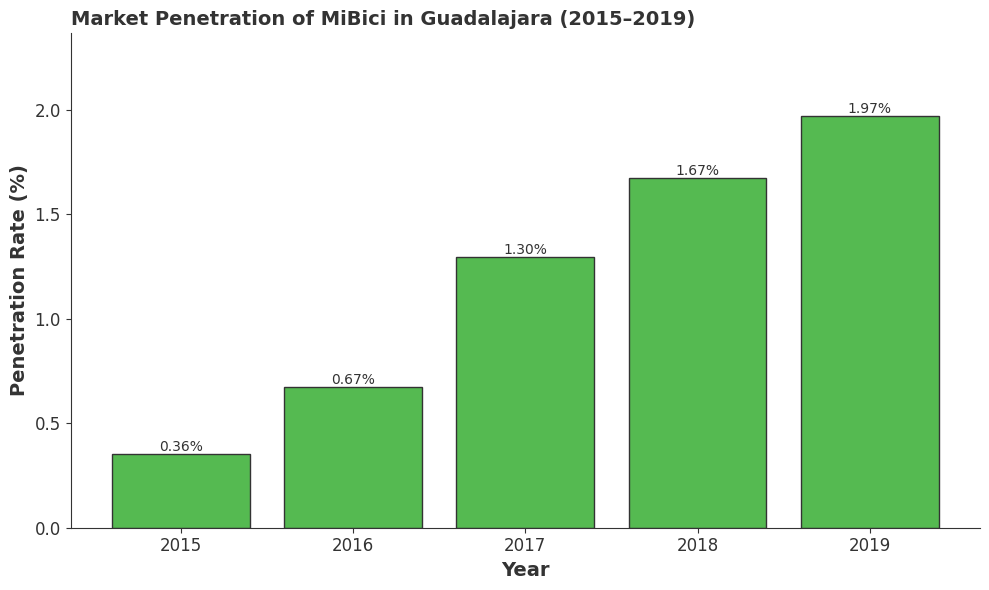

In [19]:
# جمع‌آوری داده‌های کاربران و جمعیت
result = conn.sql('''
SELECT 
  EXTRACT(YEAR FROM trip_started_at) AS year,
  COUNT(DISTINCT user_id) AS unique_users
FROM mibici_rides
WHERE trip_started_at BETWEEN '2015-01-01' AND '2019-12-31'
GROUP BY EXTRACT(YEAR FROM trip_started_at)
ORDER BY year;
''').fetchall()

# داده‌های جمعیت برای هر سال
population_data = {
    2015: 1460148,
    2016: 1483929,
    2017: 1508077,
    2018: 1532599,
    2019: 1557503
}

# استخراج داده‌ها
years = []
unique_users = []
for row in result:
    year = int(row[0])
    if year in population_data:
        years.append(year)
        unique_users.append(int(row[1]))

# محاسبه نرخ نفوذ
population = [population_data[year] for year in years]
penetration = [(u / p) * 100 for u, p in zip(unique_users, population)]

# رسم نمودار با سبک MiBici
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    years, 
    penetration, 
    color="#55BA51",        # MiBici green
    edgecolor="#333333"
)

# افزودن لیبل روی میله‌ها با استفاده از bar_label
ax.bar_label(bars, fmt='%.2f%%', fontsize=10, color="#333333")

# تنظیمات ظاهری
ax.set_title("Market Penetration of MiBici in Guadalajara (2015–2019)", fontsize=14, weight='bold', loc='left', color="#333333")
ax.set_xlabel("Year", fontsize=14, weight='bold', color="#333333")
ax.set_ylabel("Penetration Rate (%)", fontsize=14, weight='bold', color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333", rotation=0)
ax.tick_params(axis='y', labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("#333333")
#ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)
ax.set_ylim(0, max(penetration)*1.2)

# نهایی‌سازی
plt.tight_layout()
#plt.savefig("mibici_market_penetration.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Data
cities = ['Guadalajara (MiBici)', 'Mexico City (Ecobici)', 'Paris (Vélib’)', 
          'Barcelona (Bicing)', 'New York (Citi Bike)']
penetration = [1.97, 2.70, 7.20, 4.80, 1.90]  # 2019 penetration rates

# Colors: MiBici green for Guadalajara, CitiBike blue for NYC, gray for others
colors = []
for city in cities:
    if 'MiBici' in city:
        colors.append('#55BA51')  # MiBici green
    elif 'Citi Bike' in city:
        colors.append('#5BA7D4')  # Citi Bike blue
    else:
        colors.append('#CCCCCC')  # gray for others

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
bars = ax.bar(cities, penetration, color=colors, edgecolor="#333333")

# Title and labels
ax.set_title("Bike-Share Market Penetration Comparison (2019)", 
             fontsize=14, fontweight='bold', color="#333333", loc="left", pad=20)
ax.set_ylabel("Population Penetration Rate (%)", fontsize=12, weight='bold', color="#333333")
ax.tick_params(axis='x', labelsize=11, colors="#333333")
ax.tick_params(axis='y', labelsize=11, colors="#333333")
ax.set_ylim(0, 8)

# Grid and spines
ax.grid(axis='y', linestyle='--', color='#999999', alpha=0.3)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("#333333")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            height + 0.2,
            f"{height:.2f}%",
            ha='center',
            fontsize=10,
            color="#333333")

# Highlight MiBici and Citi Bike bars with thicker border
for i, city in enumerate(cities):
    if 'MiBici' in city or 'Citi Bike' in city:
        bars[i].set_linewidth(2.5)
        bars[i].set_edgecolor("black")

# Final layout
plt.tight_layout()
#plt.savefig("bike_share_penetration_comparison_highlighted.png", dpi=300)
plt.show()

# 2) Task 2 = Long-Distance Bikes
### Help design a marketing strategy for promoting new bikes intended for long-distance trips by identifying target user segments.

## 2-1) Long-Distance Rides Detection
### 📥 Data Extraction:
- Queried direct_distance_km from valid rides (distance > 0).

### 🧹 Data Cleaning:
- Replaced infinite values (inf, -inf) with NaN.

### 🧮 Threshold Calculation:
- Defined long-distance threshold using:
- Threshold=Median+2×Standard Deviation

### 📌 Key Metrics Printed:
- Displays the median, standard deviation, and final threshold value in km.

### 📈 Visualization:
- Plots histogram of trip distances

In [ ]:
# Analyzing Trip Distance Distribution and Finding the Optimal Long-Distance Threshold

# SQL Query to Extract Distance Data
result = conn.sql('''
    SELECT 
        direct_distance_km 
    FROM mibici_rides
    WHERE direct_distance_km > 0 
''').df()

# Replacing infinite values with NaN
result.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Compute Thresholds
median_distance = result['direct_distance_km'].median()
std_dev = result['direct_distance_km'].std()
long_distance_threshold = median_distance + (2 * std_dev)

# Display Threshold Values
print(f"Median Distance: {median_distance:.2f} km")
print(f"Standard Deviation: {std_dev:.2f} km")
print(f"Suggested Long-Distance Threshold: {long_distance_threshold:.2f} km")

# Plot with updated Mibici colors and typography
plt.figure(figsize=(8, 5))
sns.histplot(result['direct_distance_km'], bins=30, kde=True, color="#55BA51", stat="count")  # Green main color
plt.axvline(x=long_distance_threshold, color="#FDC820", linestyle='-.', linewidth=2, label='Threshold: Median + 2 Std Dev')  # Yellow threshold
plt.xlabel("Trip Distance (km)", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Frequency", fontsize=14, weight="bold", color="#333333")
plt.title("Trip Distance Distribution with Threshold", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
plt.legend()
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

## 2-2) Long-Distance Trips, User Behavior Analysis
### 🔍 Data Query: 
- Selected rides with distance > threshold; extracted hour, day, month, gender, age, and origin station.

### 📊 Distributions:

- Trip Start Hour – histogram 

- Day of Week & Month – bar plots 

- Gender & Age 

### 🗺️ Heatmap: 
- Visualized station usage of long-distance users with folium.

In [ ]:
import folium
from folium.plugins import HeatMap

# Get all ride records for users with long distance
long_distance_users_rides = conn.sql(f'''
    SELECT
        user_id, 
        direct_distance_km, 
        EXTRACT(HOUR FROM trip_started_at) AS trip_hour,
        STRFTIME('%w', trip_started_at) AS day_of_week,
        STRFTIME('%m', trip_started_at) AS trip_month,
        origin_station_id, gender, 
        (EXTRACT(YEAR FROM trip_started_at) - birth_year) AS age
    FROM mibici_rides
    WHERE direct_distance_km>{long_distance_threshold}
''').df()

# Define mapping for weekday numbers to names
weekday_mapping = {
    '0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday',
    '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
}

# Map and categorize weekdays
long_distance_users_rides['day_of_week'] = long_distance_users_rides['day_of_week'].astype(str).map(weekday_mapping)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
long_distance_users_rides['day_of_week'] = pd.Categorical(long_distance_users_rides['day_of_week'], categories=day_order, ordered=True)

# Distribution calculations
trip_day_distribution = long_distance_users_rides['day_of_week'].value_counts(normalize=True) * 100
trip_month_distribution = long_distance_users_rides['trip_month'].value_counts(normalize=True) * 100
trip_month_distribution = trip_month_distribution.sort_index(key=lambda x: x.astype(int))
trip_start_distribution = long_distance_users_rides['trip_hour'].value_counts(normalize=True) * 100
valid_genders = ['M', 'F']
filtered_df = long_distance_users_rides[long_distance_users_rides['gender'].isin(valid_genders)]
gender_distribution = filtered_df['gender'].value_counts(normalize=True) * 100

# Age binning
age_bins = [18, 25, 35, 45, 55, 65, 80]
age_labels = ['18-25', '25-35', '35-45', '45-55', '55-65', '65+']
long_distance_users_rides['age_bin'] = pd.cut(long_distance_users_rides['age'], bins=age_bins, labels=age_labels, include_lowest=True)
age_distribution = long_distance_users_rides['age_bin'].value_counts(normalize=True) * 100

# Set Seaborn style
sns.set_style("whitegrid")
mibici_palette = ['#3A7D44',  # سبز تیره‌تر (Sunday)
                  '#55BA51',  # سبز اصلی (Monday)
                  '#88CC88',  # سبز ملایم (Tuesday)
                  '#C4E86B',  # سبز مایل به زرد (Wednesday)
                  '#FDC820',  # زرد برند برای تأکید (Thursday)
                  '#A6A6A6',  # خاکستری برای روزهای کم‌تردد (Friday)
                  '#D9D9D9']  # خاکستری روشن برای روز تعطیل (Saturday)

# === Trip Start Time Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(data=long_distance_users_rides, x="trip_hour", bins=24, color='#55BA51', kde=True, stat="percent")
plt.xlabel("Trip Start Hour", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Percentage (%)", fontsize=14, weight="bold", color="#333333")
plt.title("Normalized Trip Start Time Distribution", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

# === Day of Week Distribution ===
plt.figure(figsize=(8, 5))
sns.barplot(x=trip_day_distribution.index, y=trip_day_distribution.values, palette=mibici_palette)
plt.xlabel("Day of the Week", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Percentage (%)", fontsize=14, weight="bold", color="#333333")
plt.title("Normalized Trip Distribution Across the Week", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

# === Month Distribution ===
plt.figure(figsize=(8, 5))
sns.barplot(x=trip_month_distribution.index, y=trip_month_distribution.values,  palette=mibici_palette)
plt.xlabel("Month", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Percentage (%)", fontsize=14, weight="bold", color="#333333")
plt.title("Normalized Trip Distribution Across the Months", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

# === Gender Distribution ===
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette=["#55BA51", "#FDC820"])
plt.xlabel("Gender", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Percentage (%)", fontsize=14, weight="bold", color="#333333")
plt.title("Normalized Gender Distribution", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

# === Age Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(data=long_distance_users_rides, x="age", bins=20, color="#55BA51", kde=True, stat="percent")
plt.xlabel("Age", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Percentage (%)", fontsize=14, weight="bold", color="#333333")
plt.title("Normalized Age Distribution of Top Users", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
sns.despine()
plt.grid(axis='y', linestyle='--', color='#333333')
plt.show()

# === Heatmap of Station Usage ===
long_distance_users_rides = long_distance_users_rides.merge(
    mibici_stations[['id', 'latitude', 'longitude']],
    left_on='origin_station_id', right_on='id', how='left'
)

station_usage = long_distance_users_rides.groupby(['latitude', 'longitude']).size().reset_index(name='count')
heat_data = station_usage[['latitude', 'longitude', 'count']].values.tolist()
map_center = [mibici_stations['latitude'].mean(), mibici_stations['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)
HeatMap(heat_data, radius=12, blur=10, max_zoom=15).add_to(m)
m.save('/kaggle/working/top_users_heatmap.html')
m

## 2-3) K-Means Clustering for Long-Trip Users
### 📌 Feature Engineering:

- Aggregated total rides & long trips per user.

- Computed long_trip_ratio.

### ⚙️ Preprocessing:

- Standardized features (num_long_trips, long_trip_ratio).

### 📈 Elbow Method:

- Tested k = 1 to 10.

- Visualized inertia to find optimal cluster count.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = conn.sql(""" 
    SELECT 
        user_id, 
        direct_distance_km, 
        EXTRACT(HOUR FROM trip_started_at) AS trip_hour, 
        STRFTIME('%w', trip_started_at) AS day_of_week,  -- '0'=Sunday, '6'=Saturday 
        STRFTIME('%m', trip_started_at) AS trip_month, 
        origin_station_id, gender, 
        (EXTRACT(YEAR FROM trip_started_at) - birth_year) AS age 
        FROM mibici_rides 
    """).df()

df["long_trip"] = (df["direct_distance_km"] > long_distance_threshold).astype(int)


# STEP 1: Aggregate Data and Compute Features
agg_df = df.groupby("user_id").agg(
    total_trips=("user_id", "count"),
    num_long_trips=("long_trip", "sum")
).reset_index()

# Compute long-trip ratio
agg_df["long_trip_ratio"] = agg_df["num_long_trips"] / agg_df["total_trips"]

# Features for clustering
features_for_clustering = agg_df[["num_long_trips", "long_trip_ratio"]]

# Scale the data before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

# STEP 2: Apply the Elbow Method
inertia = []
k_range = range(1, 11)  # Test clusters from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# STEP 3: Plot Elbow Curve using Mibici theme colors
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", linestyle="--", color="#55BA51")  # Mibici Green
plt.xlabel("Number of Clusters (k)", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Inertia (Sum of Squared Distances)", fontsize=14, weight="bold", color="#333333")
plt.title("Elbow Method for Optimal K", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
plt.grid(axis='y', linestyle='--', color='#333333')
sns.despine()
plt.show()

## 2-4) Clustering Result Visualization
### 📌 Optimal Clusters: 
- Set to 4 based on the Elbow method.

### 🏷 Cluster Assignment: 
- Users grouped by:

- Number of Long Trips

- Long Trip Ratio

### 📊 Plot:

- 2D scatter of scaled features.

- Colored by cluster labels.

In [ ]:
# Define optimal clusters (adjust based on elbow plot)
optimal_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
agg_df["cluster"] = kmeans.fit_predict(X_scaled)

# STEP 1: Visualizing Clusters
plt.figure(figsize=(8, 6))
for c in range(optimal_clusters):
    cluster_data = X_scaled[agg_df["cluster"] == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {c}")

plt.xlabel("Scaled Number of Long Trips", fontsize=14, weight="bold", color="#333333")
plt.ylabel("Scaled Long Trip Ratio", fontsize=14, weight="bold", color="#333333")
plt.title("K-Means Clustering of Users Based on Long Trip Behavior", fontsize=14, weight="bold", color="#333333")
plt.xticks(color='#333333')
plt.yticks(color='#333333')
plt.grid(True, axis='both', linestyle='--', color='gray')
plt.legend()
sns.despine()
plt.show()

## 2-5) Target User Selection from Clustering
### 📈 Step 1: Aggregate cluster stats:

- Average # of Long Trips

- Average Long Trip Ratio

- User Count per Cluster

### 🥇 Step 2: Identify target cluster with highest avg. long trips

### 🧑‍💼 Step 3: Extract user IDs in the target cluster
- Number of users selected: shown in output

In [ ]:
# STEP 1: Compute Summary Stats Per Cluster
cluster_summary = agg_df.groupby("cluster").agg(
    avg_long_trips=("num_long_trips", "mean"),
    avg_ratio=("long_trip_ratio", "mean"),
    count=("user_id", "count")
).reset_index()

print("\nCluster Summary:\n", cluster_summary)

# STEP 2: Find the Cluster with Highest Long Trips
target_cluster = cluster_summary.sort_values("avg_long_trips", ascending=False).iloc[0]["cluster"]
print("\nSelected target cluster ID:", target_cluster)

# STEP 3: Extract Users from Target Cluster
target_users = agg_df[agg_df["cluster"] == target_cluster]["user_id"].tolist()
print("Number of target users for marketing:", len(target_users))

# STEP 4: Export Target Users
target_users_df = pd.DataFrame(target_users, columns=["user_id"])
#target_users_df.to_csv("marketing_target_users_clustering.csv", index=False)

# 4) Task 4 = Growth Analysis
### (a) Has the use of bikes expanded equally across the city?
### (b) What explains the fluctuations in ride counts?

### For a detailed analysis, please refer to [my Kaggle notebook on Question 4](https://www.kaggle.com/code/alirezasalehii/alireza-mexico-mibici-question4).

# 5) Task 5 =  Loyalty Segmentation
### (a) Classify users into “loyal” vs. “occasional” and compare their demographics and usage patterns.
### (b) Do loyal users mostly use specific stations or ride across all areas?

In [ ]:
total_df = mibici_rides.copy()
total_df.loc[:, 'age'] = total_df['trip_started_at'].dt.year - total_df['birth_year']
total_df

In [ ]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## 5-1) Filter Dataframe for 2019

In [ ]:
total_rides_2019 = total_df [
    (total_df["trip_started_at"].dt.year == 2019) & (total_df["trip_ended_at"].dt.year == 2019) ]


## 5-1) Filter Dataframe for second half of 2019

In [ ]:
# فیلتر داده‌ها برای ۶ ماه دوم سال ۲۰۱۹
h2_2019 = total_rides_2019[total_rides_2019['month'].between(7, 12)]

# محاسبه تعداد سفر هر کاربر در هر ماه
rides_per_user_month_h2 = h2_2019.groupby(['user_id', 'month']).size().reset_index(name='ride_count')

# میانگین و میانه تعداد سفر ماهانه به ازای کاربر در این بازه
overall_avg_h2 = rides_per_user_month_h2['ride_count'].mean()
overall_median_h2 = rides_per_user_month_h2['ride_count'].median()

# نمایش نتایج
print(f"📊 میانگین تعداد سفر ماهانه (۶ ماه دوم): {overall_avg_h2:.2f}")
print(f"🔹 میانه تعداد سفر ماهانه (۶ ماه دوم): {overall_median_h2}")

### پس تعداد سفر در ماه رو بر اساس میانه و ۱۴ سفر می‌گذاریم


## 5-3) Mean and Median of active days oper user per month (second half of 2019)

In [ ]:
# تابع محاسبه آمار روزهای فعال
def calculate_active_day_stats(df):
    active_days = df[['user_id', 'month', 'day']].drop_duplicates()
    days_per_user_month = active_days.groupby(['user_id', 'month']).size().reset_index(name='active_days')
    mean_days = days_per_user_month['active_days'].mean()
    median_days = days_per_user_month['active_days'].median()
    return mean_days, median_days

# محاسبه برای هر بازه
mean_full, median_full = calculate_active_day_stats(total_rides_2019)
mean_half, median_half = calculate_active_day_stats(h2_2019)

# نمایش نتایج
print("📊 Active Days per User per Month:")
print(f"— Full Year (2019) -> Mean: {mean_full:.2f}, Median: {median_full}")
print(f"— Second Half (2019) -> Mean: {mean_half:.2f}, Median: {median_half}")

### پس تعداد روز فعال در ماه رو بر اساس میانه و ۸ روز درنظر می‌گیریم

## 5-4) Labeling Loyal User

### روش اول مشخص کردن کاربر وفادار: فعال بودن در حداقل ۵ ماه از ۶ ماه آخر ۲۰۱۹، ماه فعال: هر ماه حداقل ۸ روز فعال

In [ ]:
# تعداد کل کاربران فعال در ۶ ماه دوم ۲۰۱۹
total_users = h2_2019['user_id'].nunique()

# محاسبه روزهای فعال (یعنی حداقل یک سفر در یک روز)
active_days = h2_2019[['user_id', 'month', 'day']].drop_duplicates()

# شمارش تعداد روزهای فعال هر کاربر در هر ماه
days_per_user_month = active_days.groupby(['user_id', 'month']).size().reset_index(name='active_days')

# فقط ماه‌هایی که کاربر در آن >= 8 روز فعال بوده
qualified_days = days_per_user_month[days_per_user_month['active_days'] >= 8]

# شمارش ماه‌هایی که این شرط برای هر کاربر برقرار بوده
qualified_months_days = qualified_days.groupby('user_id').size().reset_index(name='qualified_months')

# کاربران وفادار: حداقل ۵ ماه با ۸ روز فعال
loyal_by_days = qualified_months_days[qualified_months_days['qualified_months'] >= 5]

# تعداد کاربران وفادار
loyal_users_count = loyal_by_days['user_id'].nunique()

# درصد کاربران وفادار
loyal_by_days_percent = 100 * loyal_users_count / total_users

# نمایش نتایج
print(f"📊 Total users (H2 2019): {total_users}")
print(f"💚 Loyal users (at least 8 active days in ≥5 months): {loyal_users_count}")
print(f"📈 Loyalty rate: {loyal_by_days_percent:.2f}%")

### روش دوم مشخص کردن کاربر وفادار: داشتن حداقل ۱۴ سفر در حداقل ۵ ماه از ۶ ماه آخر ۲۰۱۹

In [ ]:
# تعداد کل کاربران فعال در ۶ ماه دوم ۲۰۱۹
total_users = h2_2019['user_id'].nunique()

# شمارش تعداد سفر هر کاربر در هر ماه
trips_per_user_month = h2_2019.groupby(['user_id', 'month']).size().reset_index(name='trip_count')

# فقط ماه‌هایی که کاربر >= 14 سفر داشته
qualified_trips = trips_per_user_month[trips_per_user_month['trip_count'] >= 14]

# شمارش تعداد ماه‌هایی که این شرط برقرار بوده
qualified_months_trips = qualified_trips.groupby('user_id').size().reset_index(name='qualified_months')

# کاربران وفادار: حداقل ۵ ماه با 14 سفر
loyal_by_trips = qualified_months_trips[qualified_months_trips['qualified_months'] >= 5]

# تعداد کاربران وفادار
loyal_users_by_trips = loyal_by_trips['user_id'].nunique()

# درصد کاربران وفادار
loyal_by_trips_percent = 100 * loyal_users_by_trips / total_users

# نمایش نتایج
print(f"📊 Total users (H2 2019): {total_users}")
print(f"🚴 Loyal users (at least 14 trips in ≥5 months): {loyal_users_by_trips}")
print(f"📈 Loyalty rate (by trips): {loyal_by_trips_percent:.2f}%")

### اشتراک دو شرط

In [ ]:
# ادغام دو شرط با روش inner (یعنی فقط کاربرانی که هر دو شرط را دارند)
loyal_combined = pd.merge(
    loyal_by_days[['user_id']],
    loyal_by_trips[['user_id']],
    on='user_id',
    how='inner'
)

# تعداد کل کاربران در بازه ۶ ماهه دوم ۲۰۱۹
total_users = h2_2019['user_id'].nunique()

# محاسبه درصد کاربران وفادار طبق شرط ترکیبی
loyal_combined_percent = 100 * loyal_combined['user_id'].nunique() / total_users

# نمایش خروجی
print(f"✅ شرط ترکیبی (حداقل ۵ ماه با ≥۱۰ روز فعال و ≥۱۵ سفر):")
print(f"- تعداد کاربران وفادار: {loyal_combined['user_id'].nunique()}")
print(f"- درصد کاربران وفادار از کل: {loyal_combined_percent:.2f}%")

### بررسی نسبت کاربرهای وفادار به کل کاربرهایی که تابحال داشتیم

In [ ]:
# تعداد کل کاربران یکتا در کل دیتاست
total_unique_users = total_df['user_id'].nunique()

# محاسبه درصد کاربران وفادار از کل کاربران دیتاست
loyal_combined_total_percent = 100 * loyal_combined['user_id'].nunique() / total_unique_users

# نمایش خروجی
print(f"✅ درصد کاربران وفادار از کل کاربران دیتاست:")
print(f"- تعداد کل کاربران دیتاست: {total_unique_users}")
print(f"- درصد کاربران وفادار از کل دیتاست: {loyal_combined_total_percent:.2f}%")

## 5-5) Casual and Loyal Users Comparison (Age, Gender,)

In [ ]:
# 1. استخراج لیست یکتای کاربران در h2_2019
users_h2 = h2_2019[['user_id']].drop_duplicates()

# 2. ساخت ستونی به نام 'label' با مقدار پیش‌فرض 'occasional'
users_h2['label'] = 'occasional'

# 3. تغییر مقدار به 'loyal' برای کسانی که در لیست وفادارها هستند (loyal_combined از قبل ساخته شده)
users_h2.loc[users_h2['user_id'].isin(loyal_combined['user_id']), 'label'] = 'loyal'

# 4. ادغام این برچسب‌ها با داده اصلی h2_2019
h2_2019_labeled = h2_2019.merge(users_h2, on='user_id', how='left')

# نتیجه آماده برای استفاده در نمودارها و تحلیل‌ها
h2_2019_labeled

### 5-5-1) Loyal and Casual Users Age Difference

In [ ]:
import matplotlib.pyplot as plt

# 1. استخراج یک سطر برای هر کاربر با لیبل و سن
unique_users = h2_2019_labeled[['user_id', 'label', 'age']].drop_duplicates(subset='user_id')

# 2. تفکیک کاربران بر اساس لیبل
loyal_ages = unique_users[unique_users['label'] == 'loyal']['age']
occasional_ages = unique_users[unique_users['label'] == 'occasional']['age']

# 3. تعداد واقعی کاربران در هر گروه
n_loyal = len(loyal_ages)
n_occasional = len(occasional_ages)

# 4. چاپ تعداد کاربران واقعی
print(f"👥 تعداد کاربران وفادار: {n_loyal}")
print(f"👥 تعداد کاربران موردی: {n_occasional}")

# 5. رسم هیستوگرام نرمال‌شده
plt.figure(figsize=(10, 6))

# رسم هیستوگرام کاربران وفادار
plt.hist(loyal_ages, bins=20, density=True, alpha=0.6, color="#55BA51", label="Loyal Users")

# رسم هیستوگرام کاربران موردی
plt.hist(occasional_ages, bins=20, density=True, alpha=0.6, color="#FDC820", label="Occasional Users")

# 6. تنظیمات ظاهری MiBici
ax = plt.gca()
ax.set_title("Age Distribution by User Type", fontsize=14, weight='bold', loc='left', color="#333333")
ax.set_xlabel("Age", fontsize=12, weight='bold', loc='left', color="#333333")
ax.set_ylabel("Density", fontsize=12, weight='bold', color="#333333")
ax.legend(loc='upper right', title="User Type", title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.9)
ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)

# تنظیمات محورهای x و y
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.tick_params(axis='y', labelsize=12, colors="#333333")

# حذف خطوط بالایی و راست
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")

# 7. نهایی‌سازی و نمایش
plt.tight_layout()
plt.show()


### آزمون فرض

In [ ]:
from scipy.stats import mannwhitneyu

# حذف سن‌های خالی
unique_users = h2_2019_labeled[['user_id', 'label', 'age']].drop_duplicates(subset='user_id')
unique_users = unique_users.dropna(subset=['age'])

# تفکیک دو گروه
loyal_ages = unique_users[unique_users['label'] == 'loyal']['age']
occasional_ages = unique_users[unique_users['label'] == 'occasional']['age']

# بررسی اینکه لیست‌ها خالی نیستن
print(f"Loyal Users: {len(loyal_ages)}, Occasional Users: {len(occasional_ages)}")

# اجرای آزمون
stat, p_value = mannwhitneyu(loyal_ages, occasional_ages, alternative='two-sided')

# نتیجه
print("📊 Mann–Whitney U Test: Age Distribution")
print(f"Test statistic: {stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ تفاوت معناداری بین توزیع سنی کاربران وفادار و موردی وجود دارد.")
else:
    print("🔸 تفاوت معناداری بین توزیع سنی کاربران وفادار و موردی دیده نمی‌شود.")

In [ ]:
# حذف سن‌های خالی و گرفتن کاربران یکتا
unique_users = h2_2019_labeled[['user_id', 'label', 'age']].drop_duplicates(subset='user_id')
unique_users = unique_users.dropna(subset=['age'])

# تفکیک سن کاربران وفادار و موردی
loyal_ages = unique_users[unique_users['label'] == 'loyal']['age']
occasional_ages = unique_users[unique_users['label'] == 'occasional']['age']

# محاسبه میانگین و میانه
print("📊 میانگین و میانه سن کاربران:")
print(f"✅ کاربران وفادار: میانگین = {loyal_ages.mean():.1f}، میانه = {loyal_ages.median():.1f}")
print(f"🔸 کاربران موردی: میانگین = {occasional_ages.mean():.1f}، میانه = {occasional_ages.median():.1f}")

### 5-5-2) Loyal and Casual Users gender Difference

In [ ]:
import matplotlib.pyplot as plt

# 1. یکتاسازی کاربران
unique_users = h2_2019_labeled[['user_id', 'label', 'gender']].drop_duplicates(subset='user_id')
unique_users = unique_users.dropna(subset=['gender'])

# 2. شمارش کاربران برحسب جنسیت و لیبل
gender_counts = unique_users.groupby(['label', 'gender']).size().unstack(fill_value=0)

# 3. درصدگیری (نرمال‌سازی)
gender_percent = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# 4. رسم نمودار
ax = gender_percent.plot(kind='bar', stacked=False, figsize=(8, 6), color=['#55BA51', '#FDC820'])

# 5. افزودن درصد به بالای هر ستون
for i, label in enumerate(gender_percent.index):
    for j, gender in enumerate(gender_percent.columns):
        percent = gender_percent.loc[label, gender]
        ax.text(i + (j-0.5)*0.25, percent + 1, f'{percent:.1f}%', 
                ha='center', va='bottom', fontsize=10, color='black')

# 6. تنظیمات نمایشی مطابق MiBici style
ax.set_title("Gender Distribution by User Type", fontsize=14, weight='bold', loc="left", color="#333333")
ax.set_ylabel("Percentage (%)", fontsize=12, weight='bold', color="#333333")
ax.set_xlabel("User Type", fontsize=12, weight='bold', color="#333333")
ax.tick_params(axis="x", labelsize=12, colors="#333333")
ax.tick_params(axis="y", labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)
ax.legend(title='Gender', title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.7)

# 7. حذف چرخش برای عناوین محور x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# 8. نهایی‌سازی
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 1. یکتاسازی کاربران
unique_users = h2_2019_labeled[['user_id', 'label', 'gender']].drop_duplicates(subset='user_id')
unique_users = unique_users.dropna(subset=['gender'])

# 2. شمارش کاربران برحسب جنسیت و لیبل
gender_counts = unique_users.groupby(['label', 'gender']).size().unstack(fill_value=0)

# 3. درصدگیری (نرمال‌سازی)
gender_percent = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# 4. رسم نمودار
ax = gender_percent.plot(kind='bar', stacked=False, figsize=(8, 6), color=['#55BA51', '#FDC820'])

# 5. افزودن درصد به بالای هر ستون
for i, label in enumerate(gender_percent.index):
    for j, gender in enumerate(gender_percent.columns):
        percent = gender_percent.loc[label, gender]
        ax.text(i + (j-0.5)*0.25, percent + 1, f'{percent:.1f}%', 
                ha='center', va='bottom', fontsize=10, color='black')

# 6. تنظیمات نمایشی مطابق MiBici style
ax.set_title("Gender Distribution by User Type", fontsize=14, weight='bold', loc="left", color="#333333")
ax.set_ylabel("Percentage (%)", fontsize=12, weight='bold', color="#333333")
ax.set_xlabel("User Type", fontsize=12, weight='bold', color="#333333")
ax.tick_params(axis="x", labelsize=12, colors="#333333")
ax.tick_params(axis="y", labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)
ax.legend(title='Gender', title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.7)

# 7. نهایی‌سازی
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# 1. یکتاسازی کاربران برای جلوگیری از تکرار
unique_users = h2_2019_labeled[['user_id', 'label', 'gender']].drop_duplicates(subset='user_id')

# 2. حذف مقادیر جنسیت گمشده در صورت وجود
unique_users = unique_users.dropna(subset=['gender'])

# 3. ساخت جدول فراوانی (Contingency Table)
gender_table = pd.crosstab(unique_users['label'], unique_users['gender'])

# 4. اجرای آزمون کای‌دو
chi2, p, dof, expected = chi2_contingency(gender_table)

# 5. نمایش نتایج
print("📊 Chi-Square Test: Gender Distribution")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("✅ تفاوت معناداری بین توزیع جنسیت کاربران وفادار و موردی وجود دارد.")
else:
    print("🔸 تفاوت معناداری بین توزیع جنسیت کاربران وفادار و موردی دیده نمی‌شود.")

### 5-5-3) Loyal and Casual Users Trip Duration Difference

In [ ]:
import matplotlib.pyplot as plt

# 1. فیلتر داده‌ها: فقط سفرهای زیر 2 ساعت
filtered = h2_2019_labeled[
    (h2_2019_labeled['trip_duration_seconds'].notna()) &
    (h2_2019_labeled['trip_duration_seconds'] > 0) &
    (h2_2019_labeled['trip_duration_seconds'] <= 7200)
]

# 2. جدا کردن کاربران وفادار و موردی
loyal_durations = filtered[filtered['label'] == 'loyal']['trip_duration_seconds']
occasional_durations = filtered[filtered['label'] == 'occasional']['trip_duration_seconds']

# 3. ترسیم هیستوگرام
plt.figure(figsize=(10, 6))
plt.hist(loyal_durations, bins=50, density=True, alpha=0.6, color="#55BA51", label="Loyal Users")
plt.hist(occasional_durations, bins=50, density=True, alpha=0.6, color="#FDC820", label="Occasional Users")

# 4. تنظیمات نمایشی مطابق MiBici style
ax = plt.gca()
ax.set_xlabel("Trip Duration (seconds)", fontsize=12, weight='bold', color="#333333")
ax.set_ylabel("Density", fontsize=12, weight='bold', color="#333333")
ax.set_title("Trip Duration Distribution (< 2 hours) by User Type", fontsize=14, weight='bold', loc="left", color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.tick_params(axis='y', labelsize=12, colors="#333333")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("#333333")
ax.grid(axis='y', linestyle='--', color='#333333', alpha=0.3)
ax.legend(title="User Type", title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.9)

# 5. نهایی‌سازی و نمایش
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 1. فیلتر داده‌ها: فقط سفرهای زیر 2 ساعت
filtered = h2_2019_labeled[
    (h2_2019_labeled['trip_duration_seconds'].notna()) &
    (h2_2019_labeled['trip_duration_seconds'] > 0) &
    (h2_2019_labeled['trip_duration_seconds'] <= 7200)
]

# 2. جدا کردن کاربران وفادار و موردی
loyal_durations = filtered[filtered['label'] == 'loyal']['trip_duration_seconds']
occasional_durations = filtered[filtered['label'] == 'occasional']['trip_duration_seconds']

# 3. ترسیم هیستوگرام
plt.figure(figsize=(10, 6))
plt.hist(loyal_durations, bins=50, density=True, alpha=0.6, color="#55BA51", label="Loyal Users")
plt.hist(occasional_durations, bins=50, density=True, alpha=0.6, color="#FDC820", label="Occasional Users")

# 4. تنظیمات نمایشی
plt.xlabel("Trip Duration (seconds)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Trip Duration Distribution (< 2 hours) by User Type", fontsize=14, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import mannwhitneyu

# 1. فیلتر داده‌ها: فقط سفرهای زیر 2 ساعت و بدون مقدار گمشده
filtered = h2_2019_labeled[
    (h2_2019_labeled['trip_duration_seconds'].notna()) &
    (h2_2019_labeled['trip_duration_seconds'] > 0) &
    (h2_2019_labeled['trip_duration_seconds'] <= 7200)
]

# 2. جدا کردن مدت زمان‌ها برای هر گروه
loyal_durations = filtered[filtered['label'] == 'loyal']['trip_duration_seconds']
occasional_durations = filtered[filtered['label'] == 'occasional']['trip_duration_seconds']

# 3. اجرای آزمون Mann–Whitney U (دو طرفه)
stat, p_value = mannwhitneyu(loyal_durations, occasional_durations, alternative='two-sided')

# 4. چاپ نتایج
print("🧪 Mann–Whitney U Test: Trip Duration (Loyal vs. Occasional)")
print(f"Test statistic: {stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ نتیجه: تفاوت معنادار آماری بین دو گروه وجود دارد.")
else:
    print("🔸 نتیجه: تفاوت مشاهده‌شده از نظر آماری معنادار نیست.")

In [ ]:
print("⏱️ میانگین مدت استفاده (ثانیه):")
print(f"- کاربران وفادار: {loyal_durations.mean():.1f}")
print(f"- کاربران موردی: {occasional_durations.mean():.1f}")

print("\n📍 میانه مدت استفاده (ثانیه):")
print(f"- کاربران وفادار: {loyal_durations.median():.1f}")
print(f"- کاربران موردی: {occasional_durations.median():.1f}")

In [ ]:
print("📦 چارک‌ها (Q1, Median, Q3):")
print("وفادار:", loyal_durations.quantile([0.25, 0.5, 0.75]).round(1).to_dict())
print("موردی:", occasional_durations.quantile([0.25, 0.5, 0.75]).round(1).to_dict())

## 5-6) Stations Investigation

In [ ]:
stations = mibici_stations.copy()

In [ ]:
# فرض بر این است که h2_2019 و loyal_combined قبلاً ساخته شده‌اند

# 1. استخراج لیست یکتای کاربران
users_h2 = h2_2019[['user_id']].drop_duplicates()

# 2. پیش‌فرض برچسب‌گذاری کاربران به عنوان occasional
users_h2['user_label'] = 'occasional'

# 3. تغییر به loyal برای کاربران وفادار
users_h2.loc[users_h2['user_id'].isin(loyal_combined['user_id']), 'user_label'] = 'loyal'

# 4. ادغام با داده‌های ۶ ماهه دوم
h2_labeled = h2_2019.merge(users_h2, on='user_id', how='left')

### بررسی میزان استفاده از ایستگاه ها توسط کاربرهای فعال

In [ ]:
import pandas as pd
import folium

# 1️⃣ فیلتر سفرهای کاربران وفادار
loyal_rides = h2_labeled[h2_labeled['user_label'] == 'loyal']

# 2️⃣ ترکیب ستون‌های مبدا و مقصد برای شمارش کل استفاده از ایستگاه‌ها
origin_counts = loyal_rides['origin_station_id'].value_counts()
destination_counts = loyal_rides['destination_station_id'].value_counts()

# 3️⃣ ترکیب دو شمارش برای محاسبه total_usage
station_usage = pd.concat([origin_counts, destination_counts], axis=1).fillna(0)
station_usage.columns = ['origin_count', 'destination_count']
station_usage['total_usage'] = station_usage['origin_count'] + station_usage['destination_count']
station_usage = station_usage.reset_index().rename(columns={'index': 'station_id'})

# 4️⃣ ادغام با دیتای stations برای گرفتن مختصات و نام
stations['id'] = stations['id'].astype(str)
station_usage['station_id'] = station_usage['station_id'].astype(str)

station_usage = pd.merge(station_usage, stations, left_on='station_id', right_on='id', how='left')
station_usage = station_usage.dropna(subset=['latitude', 'longitude'])

# 5️⃣ ساخت نقشه با مرکزیت میانگین مختصات ایستگاه‌ها
map_center = [station_usage['latitude'].mean(), station_usage['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# 6️⃣ افزودن ایستگاه‌ها به نقشه
for _, row in station_usage.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['total_usage'] * 0.00035,
        popup=f"<b>{row['name']}</b><br>🟢 Total Usage: {int(row['total_usage'])}",
        color='darkgreen',
        fill=True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(m)

# 7️⃣ نمایش نقشه (برای Jupyter یا Colab)
m

# اگر در محیط غیر Jupyter هستید، از این خط برای ذخیره نقشه استفاده کنید:
# m.save("loyal_station_usage_map.html")


In [ ]:
import pandas as pd
import folium

# 1️⃣ استخراج سفرهای کاربران وفادار
loyal_rides = h2_labeled[h2_labeled['user_label'] == 'loyal']

# 2️⃣ شمارش دفعات استفاده از هر ایستگاه به عنوان مبدا و مقصد
origin_counts = loyal_rides['origin_station_id'].value_counts().reset_index()
destination_counts = loyal_rides['destination_station_id'].value_counts().reset_index()
origin_counts.columns = ['station_id', 'origin_count']
destination_counts.columns = ['station_id', 'destination_count']

# 3️⃣ ادغام شمارش‌ها و محاسبه مجموع استفاده
station_usage = pd.merge(origin_counts, destination_counts, on='station_id', how='outer').fillna(0)
station_usage['total_usage'] = station_usage['origin_count'] + station_usage['destination_count']

# 4️⃣ محاسبه میانگین و فیلتر ایستگاه‌های پرتکرار (بیشتر از میانگین)
mean_usage = station_usage['total_usage'].mean()
frequent_stations = station_usage[station_usage['total_usage'] > mean_usage]

# 5️⃣ ادغام با اطلاعات ایستگاه‌ها برای گرفتن مختصات و نام
stations['id'] = stations['id'].astype(str)
frequent_stations['station_id'] = frequent_stations['station_id'].astype(str)

frequent_stations = pd.merge(frequent_stations, stations, left_on='station_id', right_on='id', how='left')

# 6️⃣ تابع تعیین رنگ ایستگاه
def get_color(row):
    if row['origin_count'] > row['destination_count']:
        return 'blue'       # بیشتر مبدا بوده
    elif row['destination_count'] > row['origin_count']:
        return 'red'        # بیشتر مقصد بوده
    else:
        return 'purple'     # برابر بوده

# 7️⃣ ساخت نقشه با مرکزیت میانگین مختصات
map_center = [frequent_stations['latitude'].mean(), frequent_stations['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

# 8️⃣ اضافه کردن ایستگاه‌ها روی نقشه
for _, row in frequent_stations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['total_usage'] * 0.0003,
        popup=f"<b>{row['name']}</b><br>🚲 Origin: {int(row['origin_count'])}<br>🎯 Destination: {int(row['destination_count'])}",
        color=get_color(row),
        fill=True,
        fill_color=get_color(row),
        fill_opacity=0.7
    ).add_to(m)

# 9️⃣ نمایش نقشه در Jupyter یا ذخیره به HTML
m
# m.save("loyal_frequent_stations_map.html")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Use standard readable font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# 1. Filter loyal user rides
loyal_rides = h2_labeled[h2_labeled['user_label'] == 'loyal']

# 2. Count station usage (origin + destination)
origin_counts = loyal_rides['origin_station_id'].value_counts()
destination_counts = loyal_rides['destination_station_id'].value_counts()

station_usage = pd.concat([origin_counts, destination_counts], axis=1).fillna(0)
station_usage.columns = ['origin', 'destination']
station_usage['total'] = station_usage['origin'] + station_usage['destination']
station_usage = station_usage.sort_values(by='total', ascending=False).reset_index()

# 3. Calculate cumulative usage and percentages
station_usage['cumulative_usage'] = station_usage['total'].cumsum()
station_usage['cumulative_usage_percent'] = 100 * station_usage['cumulative_usage'] / station_usage['total'].sum()
station_usage['station_percent'] = 100 * (np.arange(1, len(station_usage)+1) / len(station_usage))

# 4. Plot the concentration curve with MiBici style
fig, ax = plt.subplots(figsize=(8,6))

# Plot the concentration curve
ax.plot(station_usage['station_percent'], station_usage['cumulative_usage_percent'], marker='o', color='#55BA51', linewidth=2)

# Labels and title with MiBici style
ax.set_xlabel('Percentage of Stations (sorted by usage)', fontsize=12, weight='bold', color="#333333")
ax.set_ylabel('Cumulative Usage (%)', fontsize=12, weight='bold', color="#333333")
ax.set_title('Usage Concentration of Loyal Users Across Stations', fontsize=14, weight='bold', loc='left', color="#333333")

# Grid and formatting
ax.grid(True, linestyle='--', color='#333333', alpha=0.3)
ax.tick_params(axis='x', labelsize=12, colors='#333333')
ax.tick_params(axis='y', labelsize=12, colors='#333333')
ax.spines[["top", "right"]].set_visible(False)  # Correct usage of ax.spines
ax.spines[["bottom", "left"]].set_color('#333333')

# Highlight 50% threshold
ax.axhline(50, color='#FDC820', linestyle='--', label='50% of Total Usage')  # Yellow line
coverage_line = station_usage[station_usage['cumulative_usage_percent'] >= 50].iloc[0]['station_percent']
ax.axvline(coverage_line, color='#F5B400', linestyle='--', label=f'{coverage_line:.1f}% of Stations')  # Orange line

# Legend with MiBici style
ax.legend(title='Thresholds', title_fontsize=12, fontsize=10, facecolor='white', framealpha=0.7)

# Final adjustments
plt.tight_layout()

# Show plot
plt.show()

# Print key insight
num_stations_50_percent = station_usage[station_usage['cumulative_usage_percent'] >= 50].index[0] + 1
print(f"📌 Only {num_stations_50_percent} stations ({coverage_line:.1f}% of all stations) account for 50% of total usage by loyal users.")


In [ ]:
def gini(array):
    array = np.sort(array)
    n = len(array)
    cumulative_sum = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative_sum) / cumulative_sum[-1]) / n

gini_score = gini(station_usage['total'].values)
print(f"Gini coefficient: {gini_score:.4f}")

In [ ]:
# 1. فیلتر سفرهای کاربران وفادار
loyal_rides = h2_labeled[h2_labeled['user_label'] == 'loyal']

# 2. استخراج ایستگاه‌های منحصربه‌فرد در مبدأ و مقصد
origin_stations = loyal_rides['origin_station_id'].unique()
destination_stations = loyal_rides['destination_station_id'].unique()

# 3. ترکیب و یکتا کردن کل ایستگاه‌ها
all_stations_used = set(origin_stations).union(set(destination_stations))

# 4. چاپ نتیجه
print(f"📍 تعداد کل ایستگاه‌هایی که کاربران وفادار از آن‌ها استفاده کرده‌اند: {len(all_stations_used)}")

# 6) Task 6 = Inactive User Segmentation
### Detect users whose activity has dropped and segment them into 3 groups to offer personalized incentives.

### For a detailed analysis, please refer to [my Kaggle notebook on Question 6](https://www.kaggle.com/code/alirezasalehii/alireza-mexico-mibici-question6).

# **CitiBike Business Questions**

# 3) Task 3 = Faulty Bike Detection
### Propose proactive methods to detect and replace damaged or worn-out bikes using usage data, before users report them.

## 3-1) Approach 1: Inactivity

In [ ]:
citibike_cleaned = citibike_rides.copy()

In [ ]:

# فرض: دیتافریم اصلی شما نامش `citibike_cleaned` است و ستون‌های زیر را دارد:
# 'bike_id', 'trip_start_date'

# مرحله 1: استخراج لیست دوچرخه‌ها
unique_bikes = citibike_cleaned['bike_id'].unique()

# مرحله 2: لیست ذخیره نتایج نهایی
bike_usage_records = []

# مرحله 3: اجرای تحلیل برای هر دوچرخه به‌صورت جداگانه
for bike_id in unique_bikes:
    df_bike = citibike_cleaned[citibike_cleaned['bike_id'] == bike_id].copy()
    
    # اطمینان از تبدیل تاریخ
    df_bike['trip_start_date'] = pd.to_datetime(df_bike['trip_start_date'])
    
    # محاسبه تعداد سفر روزانه این دوچرخه
    daily_usage = (
        df_bike.groupby('trip_start_date')
        .size()
        .reset_index(name='daily_trips')
    )

    # بازه واقعی فعالیت این دوچرخه
    start = df_bike['trip_start_date'].min()
    end = df_bike['trip_start_date'].max()
    date_range = pd.date_range(start=start, end=end)

    # ساخت ترکیب تاریخ + دوچرخه
    df_full = pd.DataFrame({'trip_start_date': date_range})
    df_full['bike_id'] = bike_id

    # ترکیب با سفرهای واقعی و جایگزینی صفر در روزهای بدون استفاده
    df_merged = df_full.merge(daily_usage, on='trip_start_date', how='left').fillna({'daily_trips': 0})

    bike_usage_records.append(df_merged)

    # (اختیاری) چاپ پیشرفت
    if len(bike_usage_records) % 500 == 0:
        print(f"✅ Processed {len(bike_usage_records)} bikes...")

# مرحله نهایی: ادغام همه دوچرخه‌ها در یک جدول
bike_daily_usage_full = pd.concat(bike_usage_records, ignore_index=True)
bike_daily_usage_full.head()

In [ ]:
from itertools import groupby

def has_7_day_gap(series, threshold=7):
    zero_streak = 0
    for trips in series:
        if trips == 0:
            zero_streak += 1
            if zero_streak >= threshold:
                return True
        else:
            zero_streak = 0
    return False

# بررسی سکون 7 روزه برای همه دوچرخه‌ها
inactive_bikes = []

for bike_id, group in bike_daily_usage_full.groupby('bike_id'):
    usage_series = group.sort_values('trip_start_date')['daily_trips'].values
    if has_7_day_gap(usage_series, threshold=7):
        inactive_bikes.append(bike_id)

print(f"🚲 Total inactive/suspected bikes (7+ days): {len(inactive_bikes)}")


In [ ]:
from itertools import groupby

def get_inactivity_summary(trips, threshold=7):
    streaks = []
    count = 0

    for t in trips:
        if t == 0:
            count += 1
        else:
            if count >= threshold:
                streaks.append(count)
            count = 0

    # بررسی آخرین دوره اگر به انتها رسیده
    if count >= threshold:
        streaks.append(count)

    return {
        'inactivity_periods': len(streaks),
        'longest_inactivity': max(streaks) if streaks else 0,
        'total_inactive_days': sum(streaks)
    }

# لیست خلاصه‌ها
summary_list = []

# اجرای تحلیل روی هر دوچرخه مشکوک
for bike_id in inactive_bikes:
    group = bike_daily_usage_full[bike_daily_usage_full['bike_id'] == bike_id]
    group_sorted = group.sort_values('trip_start_date')
    usage = group_sorted['daily_trips'].values

    stats = get_inactivity_summary(usage, threshold=7)

    summary_list.append({
        'bike_id': bike_id,
        'first_use': group_sorted['trip_start_date'].min(),
        'last_use': group_sorted['trip_start_date'].max(),
        'total_days': group_sorted['trip_start_date'].nunique(),
        'total_trips': group_sorted['daily_trips'].sum(),
        'inactivity_periods': stats['inactivity_periods'],
        'longest_inactivity': stats['longest_inactivity'],
        'total_inactive_days': stats['total_inactive_days']
    })

# تبدیل به DataFrame
summary_df = pd.DataFrame(summary_list)

# نمایش نمونه
print(f"✅ Enriched summary created for {len(summary_df)} inactive bikes.")
summary_df.head()


In [ ]:
import random
import matplotlib.pyplot as plt

# فرض: summary_df و bike_daily_usage_full در محیط شما وجود دارند

# انتخاب تصادفی 6 دوچرخه مشکوک
sample_bikes = random.sample(summary_df['bike_id'].tolist(), 6)

# فیلتر داده‌ها برای این دوچرخه‌ها
sample_data = bike_daily_usage_full[bike_daily_usage_full['bike_id'].isin(sample_bikes)]

# رسم نمودار روزانه برای هر دوچرخه
for bike_id in sample_bikes:
    bike_data = sample_data[sample_data['bike_id'] == bike_id].sort_values('trip_start_date')

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(bike_data['trip_start_date'], bike_data['daily_trips'], marker='o', color='#5BA7D4')

    # تنظیمات استایل CitiBike
    ax.set_title(f"Daily Usage of Suspicious Bike {bike_id}", fontsize=14, weight='bold', loc="left", color="#333333")
    ax.set_xlabel("Date", fontsize=12, weight='bold', color="#333333")
    ax.set_ylabel("Number of Trips", fontsize=12, weight='bold', color="#333333")
    ax.tick_params(axis="x", labelsize='large', colors="#333333")
    ax.tick_params(axis="y", labelsize='large', colors="#333333")
    
    # تنظیمات spines
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["bottom", "left"]].set_color("#333333")
    
    # تنظیمات grid
    ax.grid(True, linestyle="--", color="#333333", alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
# Distribution of Inactivity Periods per Bike
plt.figure(figsize=(10, 5))
sns.histplot(summary_df['inactivity_periods'], bins=20, color='#5BA7D4', kde=True)
plt.title("Distribution of Inactivity Periods per Bike", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Number of Inactivity Periods (≥7 days)", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Number of Bikes", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.tight_layout()
plt.show()



# Longest Inactivity Streak per Bike
plt.figure(figsize=(12, 6))
sns.boxplot(x=summary_df['longest_inactivity'], color='#5BA7D4')
median_value = summary_df['longest_inactivity'].median()
plt.title("Longest Inactivity Streak per Bike", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Days of Longest Inactivity", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.axvline(median_value, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f} days')
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Total Inactive Days per Bike
plt.figure(figsize=(10, 5))
sns.histplot(summary_df['total_inactive_days'], bins=30, color='#5BA7D4')
plt.title("Total Inactive Days per Bike", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Total Inactive Days", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Number of Bikes", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.tight_layout()
plt.show()


# Ratio of Inactive Days to Total Days
summary_df['inactive_ratio'] = summary_df['total_inactive_days'] / summary_df['total_days']
plt.figure(figsize=(10, 5))
sns.histplot(summary_df['inactive_ratio'], bins=30, color='#5BA7D4', kde=True)
plt.title("Ratio of Inactive Days to Total Days", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Inactivity Ratio", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Number of Bikes", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.tight_layout()
plt.show()


## 3-2) Approach 2: Short Trips (Duration)

In [ ]:
# مثایسه آستانه 5 , 10 درصد
threshold1 = citibike_cleaned['trip_duration_minutes'].quantile(0.05)
threshold2 = citibike_cleaned['trip_duration_minutes'].quantile(0.1)

# رسم هیستوگرام همراه با KDE
plt.figure(figsize=(10, 5))
sns.histplot(citibike_cleaned['trip_duration_minutes'], bins=100, kde=True, color='#5BA7D4')

# افزودن خط عمودی برای نمایش آستانه
plt.axvline(threshold1, color='red', linestyle='--', linewidth=2, label=f'5th Percentile: {threshold1:.2f} min')
plt.axvline(threshold2, color='yellow', linestyle='--', linewidth=2, label=f'10th Percentile: {threshold2:.2f} min')

# تنظیمات استایل CitiBike
plt.xlim(0, 60)
plt.title("Trip Duration Distribution", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Duration (minutes)", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Frequency", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")

# تنظیمات spines
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")

# تنظیمات grid
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# آستانه مدت زمان کوتاه (۵ درصد پایین‌ترین سفرها)
threshold = citibike_cleaned['trip_duration_minutes'].quantile(0.05)

# محاسبه نسبت سفرهای کوتاه برای هر دوچرخه
bike_total = citibike_cleaned.groupby('bike_id').size()
short_trips = citibike_cleaned[citibike_cleaned['trip_duration_minutes'] < threshold]
bike_short = short_trips.groupby('bike_id').size()
ratios = (bike_short / bike_total).fillna(0)

# تعریف آستانه‌ها
dynamic_threshold = ratios.quantile(0.9)

# محاسبه تعداد دوچرخه‌های مشکوک در هر روش
count_dynamic = (ratios > dynamic_threshold).sum()

# مرحله 6: چاپ تعداد دوچرخه‌های مشکوک
print(f"🚲 Suspicious Bikes Based on Dynamic 90th Percentile: {count_dynamic}")

# رسم هیستوگرام
plt.figure(figsize=(10, 5))
plt.hist(ratios, bins=50, color='#5BA7D4', edgecolor='white')
plt.axvline(dynamic_threshold, color='red', linestyle='--', linewidth=2, label=f'Dynamic (90th pct): {count_dynamic} bikes')
plt.title("Short Trip Ratio Distribution\nwith Suspicious Bike Counts", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Short Trip Ratio", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Number of Bikes", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# آستانه مدت زمان کوتاه بر اساس صدک 5٪
threshold = citibike_cleaned['trip_duration_minutes'].quantile(0.05)

# محاسبه تعداد کل سفرها و تعداد سفرهای کوتاه برای هر دوچرخه
bike_total = citibike_cleaned.groupby('bike_id').size().rename('total_trips')
short_trips = citibike_cleaned[citibike_cleaned['trip_duration_minutes'] < threshold]
bike_short = short_trips.groupby('bike_id').size().rename('short_trips')

# محاسبه نسبت سفرهای کوتاه
ratios_df = pd.concat([bike_total, bike_short], axis=1).fillna(0)
ratios_df['short_trip_ratio'] = ratios_df['short_trips'] / ratios_df['total_trips']

dynamic_threshold = ratios_df['short_trip_ratio'].quantile(0.9)
ratios_df['flagged_by_dynamic'] = ratios_df['short_trip_ratio'] > dynamic_threshold

ratios_df = ratios_df.reset_index()
print(ratios_df.head())

# فیلتر دوچرخه‌های مشکوک در روش 2 (بر اساس آستانه پویا)
bikes_suspicious_method2 = ratios_df[ratios_df['flagged_by_dynamic'] == True]

print(f"🚲 Number of suspicious bikes in Method 2: {bikes_suspicious_method2.shape[0]}")
print(bikes_suspicious_method2.head())


In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=ratios_df, 
    x='total_trips', 
    y='short_trip_ratio', 
    hue='flagged_by_dynamic', 
    palette={True: '#FF6B6B', False: '#5BA7D4'},
    alpha=0.7
)

plt.title("Short Trip Ratio vs. Total Trips", fontsize=14, weight='bold', loc="left", color="#333333")
plt.xlabel("Total Trips", fontsize=12, weight='bold', color="#333333")
plt.ylabel("Short Trip Ratio", fontsize=12, weight='bold', color="#333333")
plt.tick_params(axis="x", labelsize='large', colors="#333333")
plt.tick_params(axis="y", labelsize='large', colors="#333333")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.gca().spines[["bottom", "left"]].set_color("#333333")
plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
suspicious_bikes = ratios_df[ratios_df['flagged_by_dynamic'] == True]['bike_id'].tolist()
sample_bikes = random.sample(suspicious_bikes, 6)

# فیلتر کردن داده مصرف روزانه
sample_usage = bike_daily_usage_full[bike_daily_usage_full['bike_id'].isin(sample_bikes)]

# ترسیم نمودار برای هر دوچرخه
for bike_id in sample_bikes:
    bike_data = sample_usage[sample_usage['bike_id'] == bike_id].sort_values('trip_start_date')

    plt.figure(figsize=(12, 4))
    plt.plot(bike_data['trip_start_date'], bike_data['daily_trips'], marker='o', color='#5BA7D4')
    plt.title(f"Daily Usage of Suspicious Bike {bike_id}", fontsize=14, weight='bold', loc="left", color="#333333")
    plt.xlabel("Date", fontsize=12, weight='bold', color="#333333")
    plt.ylabel("Number of Trips", fontsize=12, weight='bold', color="#333333")
    plt.tick_params(axis="x", labelsize='large', colors="#333333")
    plt.tick_params(axis="y", labelsize='large', colors="#333333")
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.gca().spines[["bottom", "left"]].set_color("#333333")
    plt.grid(True, linestyle="--", color="#333333", alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3-3) Approach 3 (Passive Detection)

In [ ]:
#!pip install pendulum
#!pip install pykalman

In [ ]:
import io
import requests
import zipfile
import glob
import os
import shutil
from pprint import pprint
import datetime
from bs4 import BeautifulSoup
import pendulum
from datetime import timedelta
from pykalman import KalmanFilter
import holidays

### Generate all dates from 2013-06-01 to 2013-12-31¶

In [ ]:
# # • Generate all dates from 2013-06-01 to 2013-12-31.
# date_range = pd.date_range(start="2013-06-01", end="2013-12-31", freq="D")
# date_df = pd.DataFrame({"day": date_range})

# # • Extract month and week information.
# date_df["month"] = date_df["day"].dt.strftime("%Y-%m")
# date_df["week"] = date_df["day"].dt.strftime("%Y-%m week %U")

# # • Retrieve all unique bike IDs.
# bike_ids = conn.sql('SELECT DISTINCT bike_id FROM citibike_rides;').df()

# # • Create full timeline per bike.
# trips_drop = bike_ids.merge(date_df, how="cross")

# # • Query to retrieve trip counts and usage metrics.
# trips_data = conn.sql('''
#     SELECT 
#         bike_id, 
#         trip_start_date AS day, 
#         COUNT(*) AS this_day_trips,
#         AVG(trip_duration_seconds) / 60 AS this_day_avg_time_usage,  -- Convert seconds to minutes
#         AVG(speed_kmh) AS this_day_avg_speed
#     FROM citibike_rides
#     GROUP BY bike_id, trip_start_date;
# ''').df()

# # • Merge trip data into `trips_drop`.
# trips_drop = trips_drop.merge(trips_data, on=["bike_id", "day"], how="left")

# # • Fill missing values for bikes with no recorded trips.
# trips_drop[["this_day_trips", "this_day_avg_time_usage", "this_day_avg_speed"]] = trips_drop[
#     ["this_day_trips", "this_day_avg_time_usage", "this_day_avg_speed"]
# ].fillna(0)

# trips_drop["total_previous_trips"] = trips_drop.groupby("bike_id")["this_day_trips"].cumsum()
# trips_drop["total_previous_time_usage"] = trips_drop.groupby("bike_id")["this_day_avg_time_usage"].cumsum()
# trips_drop["total_previous_distance"] = trips_drop.groupby("bike_id")["this_day_avg_speed"].cumsum()  # Using speed * time for estimate

# # • Reset first day's values to zero.
# trips_drop["total_previous_trips"] = trips_drop.groupby("bike_id")["total_previous_trips"].transform(lambda x: x - x.iloc[0])
# trips_drop["total_previous_time_usage"] = trips_drop.groupby("bike_id")["total_previous_time_usage"].transform(lambda x: x - x.iloc[0])
# trips_drop["total_previous_distance"] = trips_drop.groupby("bike_id")["total_previous_distance"].transform(lambda x: x - x.iloc[0])

### Applying Kalman Filter to Data¶

In [ ]:
# # • Initialize the Kalman filter.
# kf = KalmanFilter(initial_state_mean=trips_drop["this_day_trips"].iloc[0], n_dim_obs=1)

# # • Apply Kalman filter for smoother trip count.
# trips_drop["trips_kfilter"], _ = kf.smooth(trips_drop["this_day_trips"].values)

# # • Apply Kalman filter for smoother time usage.
# trips_drop["time_usage_kfilter"], _ = kf.smooth(trips_drop["this_day_avg_time_usage"].values)

# # • Apply Kalman filter for smoother speed.
# trips_drop["speed_kfilter"], _ = kf.smooth(trips_drop["this_day_avg_speed"].values)

### Calculating the slope of the Kalman filter line¶

In [ ]:
# # Compute slope for each bike using the previous day's values.
# trips_drop["trips_slope"] = trips_drop.groupby("bike_id")["trips_kfilter"].diff()
# trips_drop["time_usage_slope"] = trips_drop.groupby("bike_id")["time_usage_kfilter"].diff()
# trips_drop["speed_slope"] = trips_drop.groupby("bike_id")["speed_kfilter"].diff()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mehdiaryaee/citibike2013")

print("Path to dataset files:", path)

trips_drop = pd.read_parquet('/kaggle/input/citibike2013/trips_drop.parquet')

In [ ]:
# Get U.S. holidays for New York
ny_holidays = holidays.US(state='NY')

# Convert day column to datetime
trips_drop['day'] = pd.to_datetime(trips_drop['day'])

# Function to determine if the day is a working day
def is_working_day(date):
    if date.weekday() >= 5 or date in ny_holidays:  # Saturday-Sunday + holiday check
        return False
    return True

# Apply function to create is_working_day column
trips_drop['is_working_day'] = trips_drop['day'].apply(is_working_day)

### Finding Inactive Bikes: Passive Method¶

In [ ]:
# Drop NaN values from trips_kfilter
cleaned_trips_drop = trips_drop.dropna(subset=["trips_kfilter"])

# Filter rows where this_day_trips is 0
filtered_data = cleaned_trips_drop[
# cleaned_trips_drop["this_day_trips"] == 0
    (cleaned_trips_drop["this_day_trips"] == 0) &
    (cleaned_trips_drop["is_working_day"] == True)
]

# Calculate the median of trips_kfilter
threshold_trips_kfilter = filtered_data["trips_kfilter"].median()

# Display the result
print(f"Median of trips_kfilter for inactive bikes: {threshold_trips_kfilter}")

# to find inactive bike
inactive_bikes = trips_drop[
    (trips_drop["this_day_trips"] == 0) &
    (trips_drop["total_previous_trips"] > 1) &
    (trips_drop["trips_kfilter"] <= threshold_trips_kfilter) 
]

In [ ]:
# Add a column indicating the next day's inactivity
inactive_bikes["next_day_inactive"] = inactive_bikes.groupby("bike_id")["day"].diff().dt.days == 1

# Identify start dates of inactivity periods
inactive_start_day = inactive_bikes[inactive_bikes["next_day_inactive"] == False]

### Number of Inactive Bikes Using Passive Method¶

In [ ]:
# Count inactive bike entries per month
inactive_bikes_per_month = inactive_start_day.groupby("month").size().reset_index()

# Rename columns
inactive_bikes_per_month.columns = ['month', 'inactive_bike_count']

# Display the table
inactive_bikes_per_month.head(7)

## 3-4) Approach 4:  Active Method¶ (Prediction)

In [ ]:
# Calculate median values for relevant features
median_values = inactive_start_day[[
    "this_day_trips",
    "this_day_avg_time_usage",
    "this_day_avg_speed",
    "trips_slope",
    "time_usage_slope",
    "speed_slope"
]].median()

# Define thresholds based on median values
threshold_this_day_trips = median_values["this_day_trips"]
threshold_this_day_avg_time_usage = median_values["this_day_avg_time_usage"]
threshold_this_day_avg_speed = median_values["this_day_avg_speed"]
threshold_trips_slope = median_values["trips_slope"]
threshold_time_usage_slope = median_values["time_usage_slope"]
threshold_speed_slope = median_values["speed_slope"]

pprint(median_values)

In [ ]:
# For each bike_id, get the working-day flag for the next row.
# If the next row doesn't exist (e.g., on the last record per bike), we fill with False.
if "is_holiday" in trips_drop.columns:
    trips_drop["is_working_day"] = trips_drop["is_working_day"] & (~trips_drop["is_holiday"])

trips_drop["next_is_working_day"] = (
    trips_drop.groupby("bike_id")["is_working_day"].shift(-1).fillna(False)
)

# Now, apply your filtering including the extra condition
suspicious_bicycles = trips_drop[
    (trips_drop["this_day_trips"] <= threshold_this_day_trips) &
    (trips_drop["this_day_avg_time_usage"] <= threshold_this_day_avg_time_usage) &
    (trips_drop["this_day_avg_speed"] <= threshold_this_day_avg_speed) &
    (trips_drop["trips_slope"] <= threshold_trips_slope) &
    (trips_drop["time_usage_slope"] <= threshold_time_usage_slope) &
    (trips_drop["speed_slope"] <= threshold_speed_slope) &
    (trips_drop["total_previous_trips"] > 1) &
    (trips_drop["is_working_day"]) &          # The row's day is not holiday/weekend
    (trips_drop["next_is_working_day"])         # The next row's day is not holiday/weekend
]

# Drop duplicates based on bike_id and total_previous_trips, keeping the first occurrence
suspicious_bicycles = suspicious_bicycles.drop_duplicates(subset=["bike_id", "total_previous_trips"], keep="first")

### Number of Inactive Bikes Using Active Method¶

In [ ]:
# Count inactive bike entries per month
inactive_bikes_per_month = suspicious_bicycles.groupby("month").size().reset_index()

# Rename columns
inactive_bikes_per_month.columns = ['month', 'inactive_bike_count']

# Display the table
inactive_bikes_per_month.head(7)

In [ ]:
# Set the bike ID dynamically
bike_id_to_plot = np.random.choice(trips_drop["bike_id"].unique())

# Filter the dataset for the selected bike
bike_trips = trips_drop[trips_drop["bike_id"] == bike_id_to_plot]

# Create a figure and axis
plt.figure(figsize=(24, 12))

# Plot trip trends for the selected bike
plt.plot(bike_trips["day"], bike_trips["this_day_trips"], label="Daily trips", color="#343D72", linewidth=2)  # Main color

# For inactive events:
filtered_inactive = inactive_bikes[inactive_bikes["bike_id"] == bike_id_to_plot]

# Plot a different marker (e.g., an orange circle) for each inactive day at the level y_marker
plt.scatter(filtered_inactive['day'], [0] * len(filtered_inactive), 
            color="orange", marker="o", s=200, label="Inactive Event")

# Get non-working days (where is_working_day is False)
non_working_days = bike_trips[bike_trips["is_working_day"] == False]["day"].unique()

# Ensure that only one legend entry appears
label_used = False  
for non_working_day in non_working_days:
    if not label_used:
        plt.scatter(non_working_day, 0, color="yellow", marker="o", s=50, label="Weekend/Holiday")
        label_used = True
    else:
        plt.scatter(non_working_day, 0, color="yellow", marker="o", s=50)

filtered_data = suspicious_bicycles[suspicious_bicycles['bike_id'] == bike_id_to_plot]
for day in filtered_data['day']:
    plt.axvline(x=day, color="r", linestyle="-.", alpha=0.7, label=f'At Risk: Bike {bike_id_to_plot} - {day.date()}')  # Complementary color

# Set labels and title
plt.xlabel("Date", fontsize=14, weight="bold", color="gray")
plt.ylabel("Number of trips", fontsize=14, weight="bold", color="gray")
plt.title(f"Trip Trends for Bike {bike_id_to_plot}", fontsize=16, weight="bold", color="gray")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, color="gray")

# Add grid and legend
plt.grid(True, linestyle="--", alpha=0.5, color="gray")
plt.legend()

# Show plot
plt.show()

# 7) Task 7 = Operational Optimization 
### (a) Would rebalancing bikes between stations more frequently increase revenue?
### (b) Would expanding the bike fleet and stations be a profitable investment?

## 7-1) Rebalancing

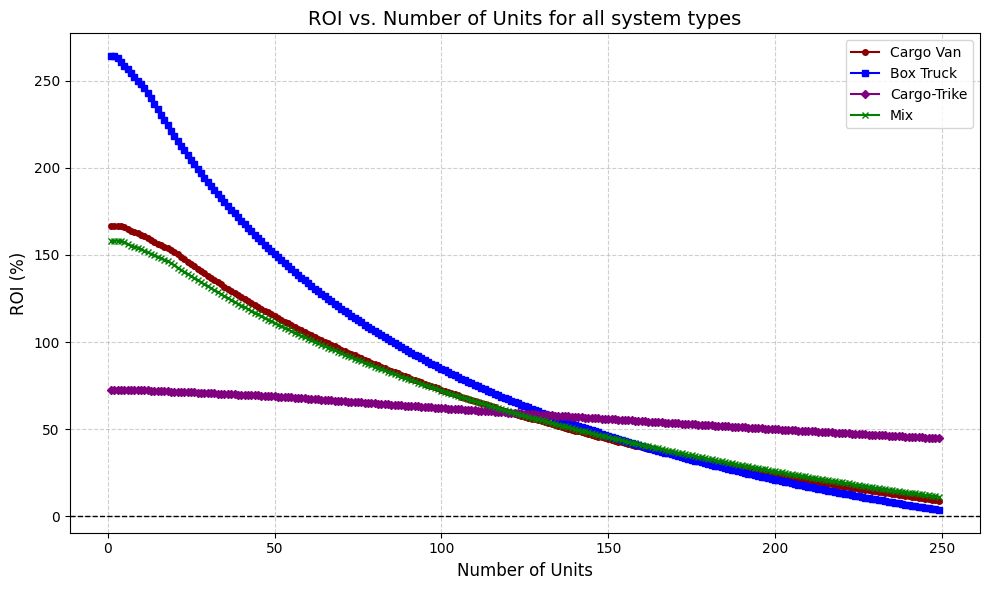

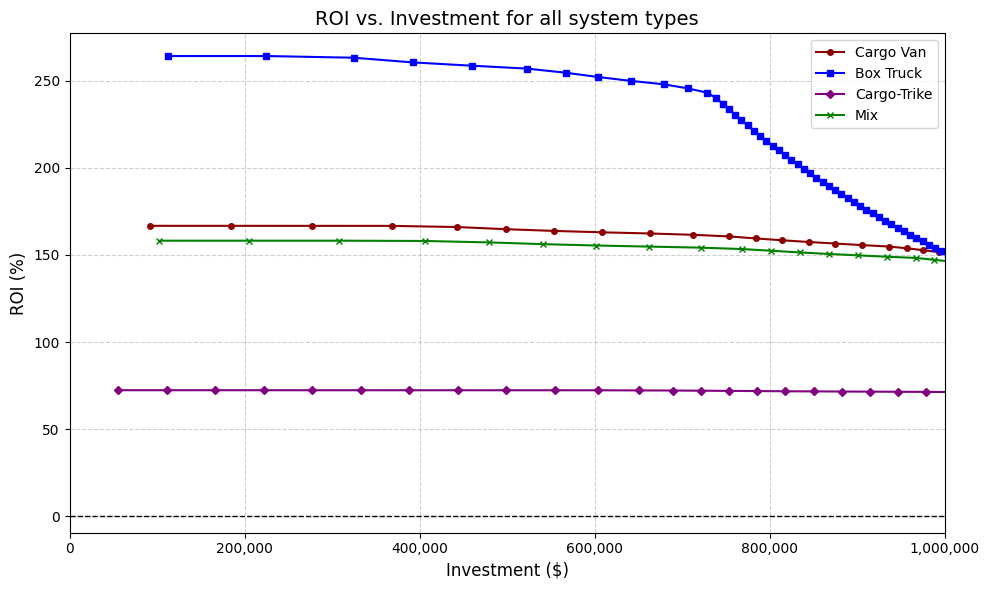

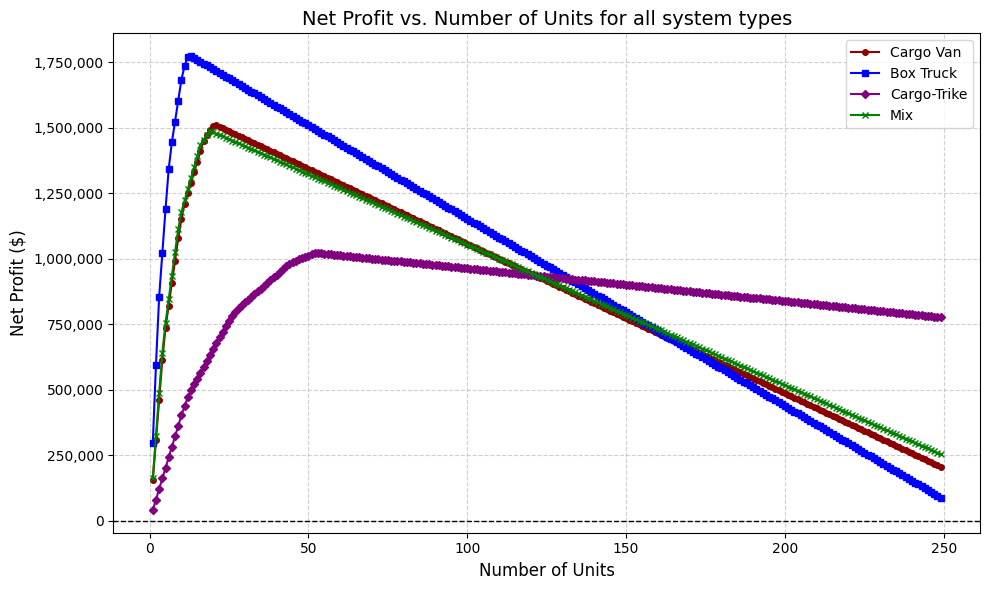

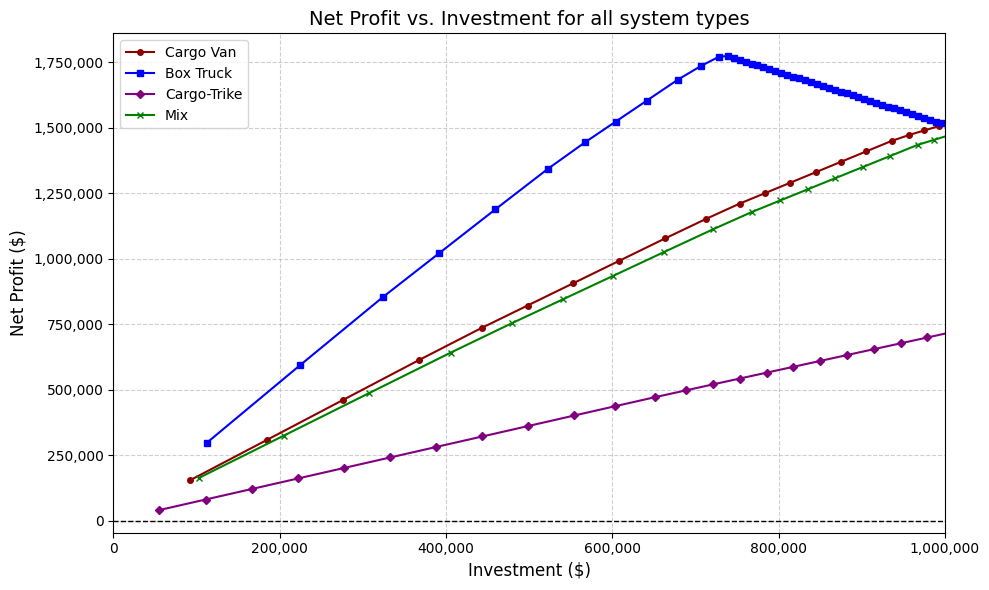

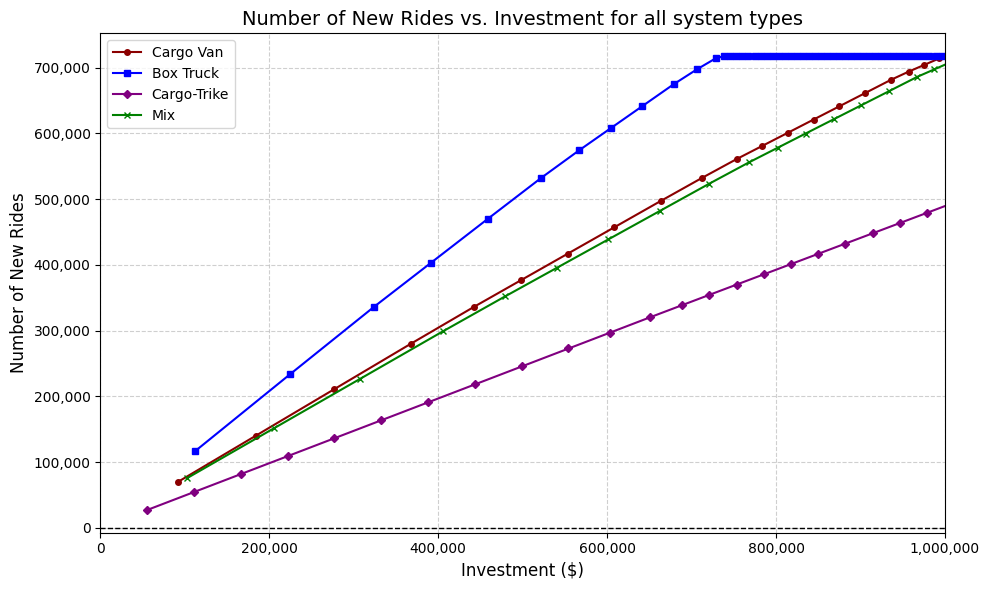

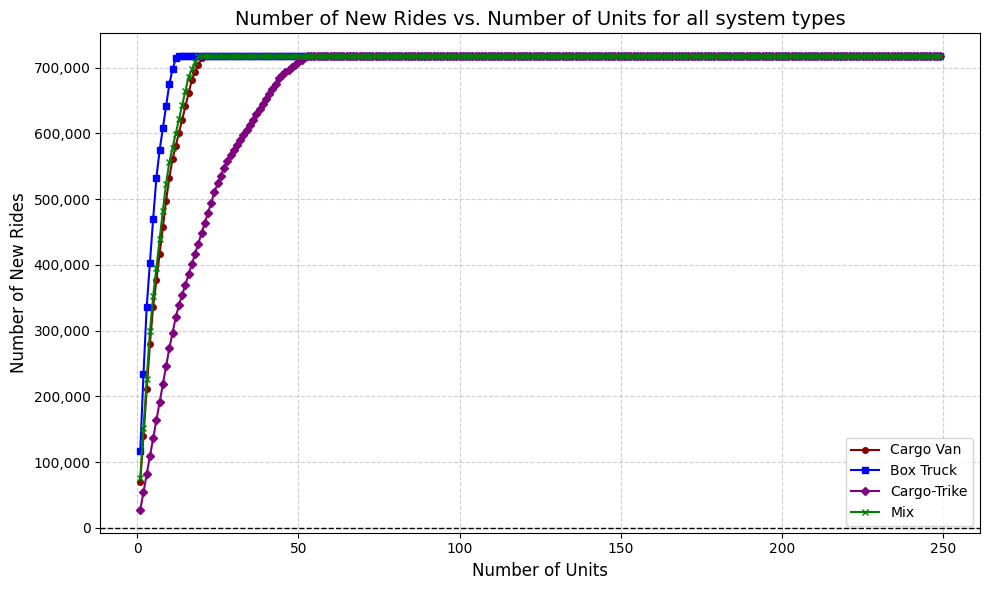

In [2]:
# ====== BEGIN REBALANCING SYSTEMS SENSITIVITY ANALYSIS CODE ======

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# -------------------------------------------------------
# 1. PARAMETERS / ASSUMPTIONS

# Monthly imbalance (move) events from Jun-Dec 2013
# (These are the monthly limits; moves in any month cannot exceed these.)
monthly_imbalance = np.array([17776, 22125, 48784, 77698, 91629, 42859, 21200])
# Total moves from these 7 months = 322,071 and average is 46,010; however, we now use the actual monthly values.

# Each move generates 1.3 new rides.
# With a revenue per ride of $3.50, revenue per move = 1.3 x 3.50 ≈ $4.55.
revenue_per_move_generated = 1.3 * 3.50  # $4.55

# Annualization factor: We will take the sum over 7 months and multiply by (12/7)
annualization_factor = 12 / 7

# Define the rebalancing systems. For each, specify:
#   - capacity: moves per month per unit (if unconstrained)
#   - cost: purchase cost in dollars
#   - life: lifespan in years
#   - om_cost: additional operating cost per move (Labor + Fuel/Upkeep), in dollars
system_types = [
    {
        "name": "Cargo Van",
        "capacity": 4500,    # moves/month per unit
        "cost": 40000,       # dollars
        "life": 7,           # years
        "om_cost": 1.60      # dollars per move (labor + fuel/upkeep)
    },
    {
        "name": "Box Truck",
        "capacity": 7500,    # moves/month per unit
        "cost": 50000,       # dollars
        "life": 7,           # years
        "om_cost": 1.17      # dollars per move
    },
    {
        "name": "Cargo-Trike",
        "capacity": 1750,    # moves/month per unit
        "cost": 7500,        # dollars
        "life": 6,           # years
        "om_cost": 2.58      # dollars per move
    },
    {
        "name": "Mix",
        "capacity": 4850,    # weighted capacity: 0.5*4500 + 0.3*7500 + 0.2*1750
        "cost": 36500,       # weighted cost: 0.5*40000 + 0.3*50000 + 0.2*7500
        "life": 6.8,         # weighted average life (years)
        "om_cost": 1.67      # weighted operating cost per move
    }
]

# Range of units to simulate (from 1 to 70 units)
units_range = np.arange(1, 250, 1)

# Define plotting styles for each system type.
plot_styles = {
    "Cargo Van":    {"color": "darkred", "marker": "o"},
    "Box Truck":    {"color": "blue",    "marker": "s"},
    "Cargo-Trike":  {"color": "purple",  "marker": "D"},
    "Mix":          {"color": "green",   "marker": "x"}
}

# -------------------------------------------------------
# 2. COMPUTE THE SENSITIVITY DATA

# For each system type and each number of units, we:
#   - Compute the “unconstrained” total capacity per month = units * capacity.
#   - For each month (from monthly_imbalance), the effective moves = min(total_capacity, monthly_imbalance_for_that_month).
#   - Sum effective moves over the 7 months; then annualize the value by multiplying by (12/7).
#   - Annual Revenue = (annualized effective moves) * (revenue per move)
#   - Operating Cost = (annualized effective moves) * (om_cost)
#   - Capital Cost = units * (system_cost / life)
#   - Total Investment = Capital Cost + Operating Cost
#   - Net Profit = Annual Revenue - Total Investment
#   - ROI = (Net Profit / Total Investment) * 100
#   - Annual New Rides = (annualized effective moves) * 1.3

rows = []
for system in system_types:
    system_name   = system["name"]
    unit_capacity = system["capacity"]  # unconstrained moves per month per unit
    system_cost   = system["cost"]
    system_life   = system["life"]
    om_cost       = system["om_cost"]
    
    # Annualized capital cost per unit.
    def capital_cost(units):
        return units * (system_cost / system_life)
    
    for units in units_range:
        # Unconstrained monthly capacity provided by 'units'
        total_capacity = units * unit_capacity
        
        # For each month, effective moves = min(total_capacity, monthly imbalance)
        effective_moves_monthly = np.minimum(total_capacity, monthly_imbalance)
        sum_effective_moves = np.sum(effective_moves_monthly)
        
        # Annualized effective moves (scaled to 12 months)
        annual_effective_moves = sum_effective_moves * annualization_factor
        
        # Annual Revenue (using $4.55 per move)
        annual_revenue = annual_effective_moves * revenue_per_move_generated
        
        # Operating cost: (annual effective moves * om_cost)
        operating_cost = annual_effective_moves * om_cost
        
        # Capital cost (annualized)
        cap_cost = capital_cost(units)
        
        # Total Annual Investment = Capital cost + Operating cost
        total_investment = cap_cost + operating_cost
        
        # Net Profit and ROI – note that these could be negative.
        net_profit = annual_revenue - total_investment
        roi = (net_profit / total_investment * 100) if total_investment > 0 else 0
        
        # Annual New Rides generated
        annual_new_rides = annual_effective_moves * 1.3
        
        rows.append({
            "System Type": system_name,
            "Units": units,
            "Total Capacity (moves/month)": total_capacity,
            "Annual Effective Moves": annual_effective_moves,
            "Annual Revenue ($)": annual_revenue,
            "Capital Investment ($)": cap_cost,
            "Operating Cost ($)": operating_cost,
            "Investment ($)": total_investment,
            "Net Profit ($)": round(net_profit, 2),
            "ROI (%)": round(roi, 2),
            "Annual New Rides": round(annual_new_rides, 2)
        })

df_sensitivity = pd.DataFrame(rows)

# -------------------------------------------------------
# 3. PLOT DIAGRAMS
# We'll produce six diagrams:
# 1. ROI vs. Number of Units
# 2. ROI vs. Investment
# 3. Net Profit vs. Number of Units
# 4. Net Profit vs. Investment
# 5. Number of New Rides vs. Investment
# 6. Number of New Rides vs. Number of Units
# For diagrams with Investment on the x-axis, limit the x-axis to 150,000.
# The tick labels are formatted with comma separators.

# Diagram 1: ROI vs. Number of Units for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Units"], subset["ROI (%)"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Number of Units", fontsize=12)
plt.ylabel("ROI (%)", fontsize=12)
plt.title("ROI vs. Number of Units for all system types", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 2: ROI vs. Investment for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Investment ($)"], subset["ROI (%)"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("ROI (%)", fontsize=12)
plt.title("ROI vs. Investment for all system types", fontsize=14)
plt.xlim(0, 1000000)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 3: Net Profit vs. Number of Units for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Units"], subset["Net Profit ($)"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Number of Units", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Net Profit vs. Number of Units for all system types", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 4: Net Profit vs. Investment for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Investment ($)"], subset["Net Profit ($)"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Net Profit vs. Investment for all system types", fontsize=14)
plt.xlim(0, 1000000)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 5: Number of New Rides vs. Investment for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Investment ($)"], subset["Annual New Rides"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("Number of New Rides", fontsize=12)
plt.title("Number of New Rides vs. Investment for all system types", fontsize=14)
plt.xlim(0, 1000000)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 6: Number of New Rides vs. Number of Units for all system types
plt.figure(figsize=(10, 6))
for system in system_types:
    sys_name = system["name"]
    style = plot_styles[sys_name]
    subset = df_sensitivity[df_sensitivity["System Type"] == sys_name]
    plt.plot(subset["Units"], subset["Annual New Rides"],
             label=sys_name,
             color=style["color"],
             marker=style["marker"],
             linestyle="-", markersize=4)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Number of Units", fontsize=12)
plt.ylabel("Number of New Rides", fontsize=12)
plt.title("Number of New Rides vs. Number of Units for all system types", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# ====== END REBALANCING SYSTEMS SENSITIVITY ANALYSIS CODE ======

## 7-3) Expansion

,Bike Type,New Bikes,Total Fleet,Monthly New Rides,Annual New Revenue ($),New Docks,New Stations,Cost Bikes ($),Cost Docks ($),Cost Stations ($),Installation Labor ($),Total Capex ($),Net Profit ($),ROI (%),Investment ($)
0,Standard,1,6001,50.0,2100.0,0,0,1200,0,0,0,1200,900.0,75.00,1200
1,Standard,2,6002,100.0,4200.0,1,0,2400,1000,0,0,3400,800.0,23.53,3400
2,Standard,3,6003,150.0,6300.0,2,0,3600,2000,0,0,5600,700.0,12.50,5600
3,Standard,4,6004,200.0,8400.0,3,0,4800,3000,0,0,7800,600.0,7.69,7800
4,Standard,5,6005,250.0,10500.0,4,0,6000,4000,0,0,10000,500.0,5.00,10000
5,Standard,6,6006,300.0,12600.0,4,0,7200,4000,0,0,11200,1400.0,12.50,11200
6,Standard,7,6007,350.0,14700.0,5,0,8400,5000,0,0,13400,1300.0,9.70,13400
7,Standard,8,6008,400.0,16800.0,6,0,9600,6000,0,0,15600,1200.0,7.69,15600
8,Standard,9,6009,450.0,18900.0,7,0,10800,7000,0,0,17800,1100.0,6.18,17800
9,Standard,10,6010,500.0,21000.0,8,0,12000,8000,0,0,20000,1000.0,5.00,20000


,Bike Type,New Bikes,Total Fleet,Monthly New Rides,Annual New Revenue ($),New Docks,New Stations,Cost Bikes ($),Cost Docks ($),Cost Stations ($),Installation Labor ($),Total Capex ($),Net Profit ($),ROI (%),Investment ($)
19986,Mix,4990,10990,480000.0,20160000.0,3992,199,10728500,3992000,2985000,597000,18302500,1857500.0,10.15,18302500
19987,Mix,4991,10991,480000.0,20160000.0,3992,199,10730650,3992000,2985000,597000,18304650,1855350.0,10.14,18304650
19988,Mix,4992,10992,480000.0,20160000.0,3993,199,10732800,3993000,2985000,597000,18307800,1852200.0,10.12,18307800
19989,Mix,4993,10993,480000.0,20160000.0,3994,199,10734950,3994000,2985000,597000,18310950,1849050.0,10.10,18310950
19990,Mix,4994,10994,480000.0,20160000.0,3995,199,10737100,3995000,2985000,597000,18314100,1845900.0,10.08,18314100
19991,Mix,4995,10995,480000.0,20160000.0,3996,199,10739250,3996000,2985000,597000,18317250,1842750.0,10.06,18317250
19992,Mix,4996,10996,480000.0,20160000.0,3996,199,10741400,3996000,2985000,597000,18319400,1840600.0,10.05,18319400
19993,Mix,4997,10997,480000.0,20160000.0,3997,199,10743550,3997000,2985000,597000,18322550,1837450.0,10.03,18322550
19994,Mix,4998,10998,480000.0,20160000.0,3998,199,10745700,3998000,2985000,597000,18325700,1834300.0,10.01,18325700
19995,Mix,4999,10999,480000.0,20160000.0,3999,199,10747850,3999000,2985000,597000,18328850,1831150.0,9.99,18328850


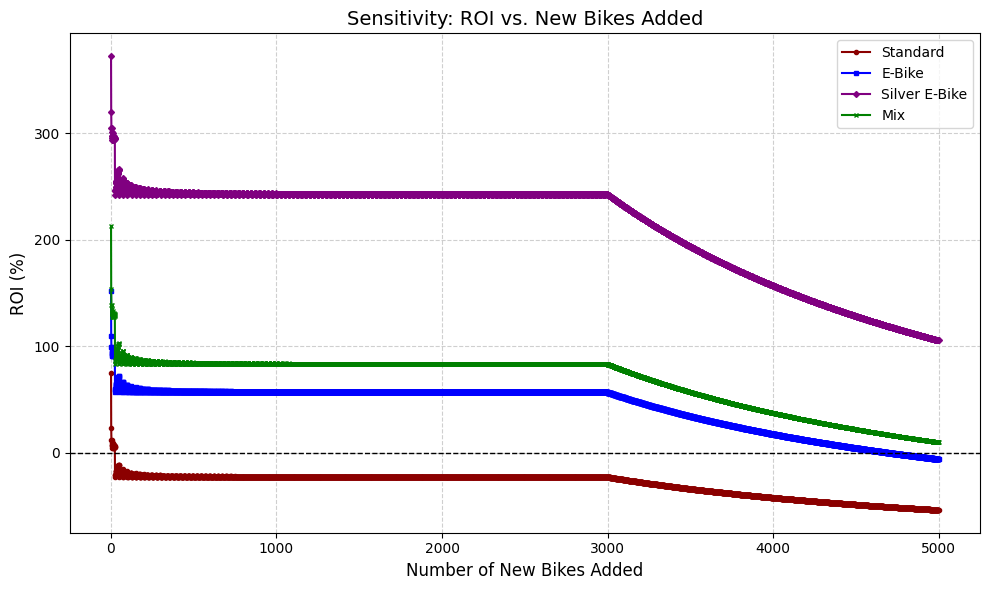

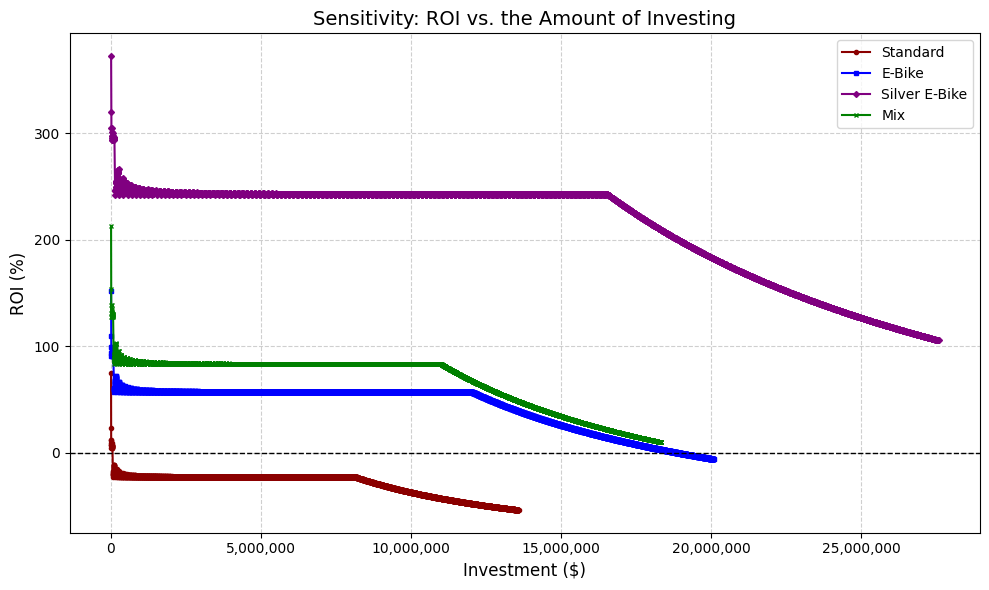

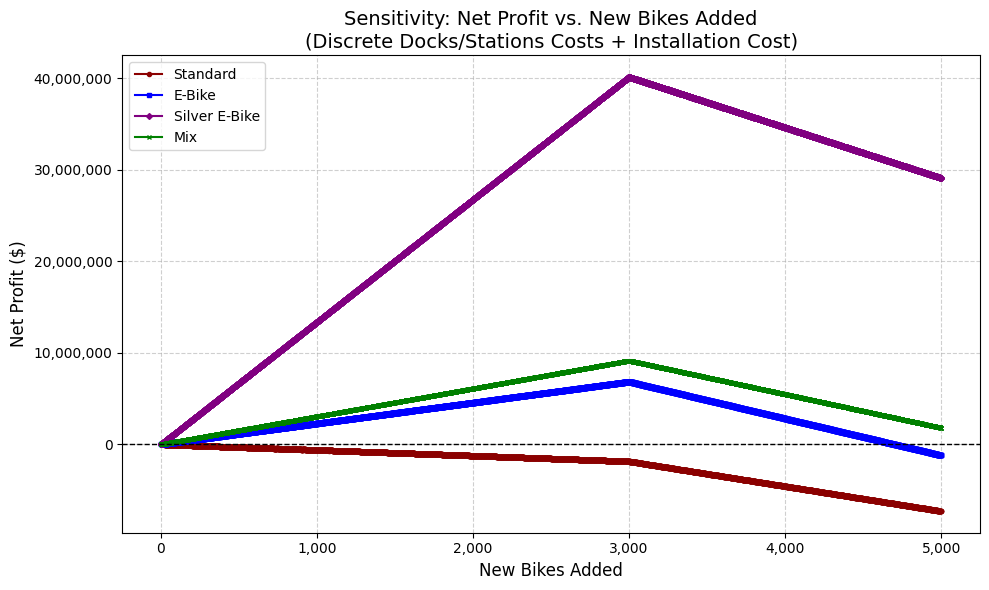

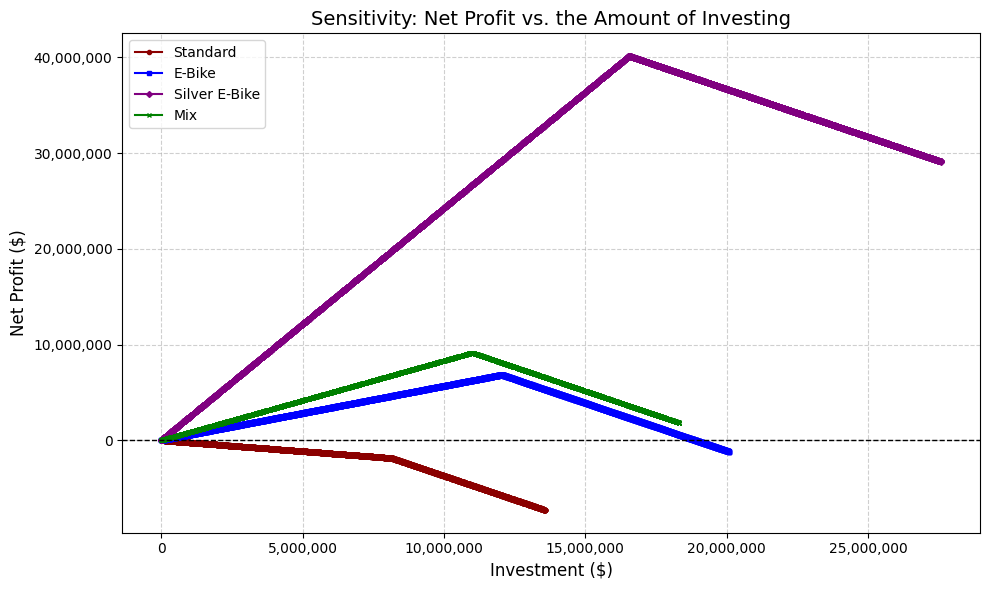

In [3]:
# ====== BEGIN COMPLETE MULTI-TYPE SENSITIVITY ANALYSIS CODE ======

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# -------------------------------------------------------
# 1. PARAMETERS / ASSUMPTIONS

# Existing fleet and service-area population
current_fleet      = 6000
population         = 3_000_000
# Saturation threshold: 3 bikes per 1,000 residents
saturation_fleet   = 3 * (population / 1000)

# Revenue per ride (assumed the same for all bike types)
avg_rev_per_ride   = 3.50  # in dollars

# Capital cost benchmarks (Year 0) - common for all types
docks_per_bike     = 0.8    # new docks required per new bike
cost_dock          = 1000   # cost per dock
docks_per_station  = 20     # docks per station
cost_station       = 15000  # cost per station
labor_per_station  = 3000   # installation labor cost per station

# Define bike types:
# - Standard: cost = 1200, rides/month = 50
# - E-Bike: cost = 2500, rides/month = 150
# - Silver E-Bike: cost = 4000, rides/month = 450
# - Mix: 50% Standard, 30% E-Bike, 20% Silver E-Bike -> cost = 2150, rides/month = 160
bike_types = [
    {"name": "Standard",      "cost_bike": 1200, "rides_per_bike": 50},
    {"name": "E-Bike",        "cost_bike": 2500, "rides_per_bike": 150},
    {"name": "Silver E-Bike", "cost_bike": 4000, "rides_per_bike": 450},
    {"name": "Mix",           "cost_bike": 2150, "rides_per_bike": 160}
]

# Range of new bikes to test (for each type)
new_bikes_range = np.arange(1, 5000, 1)

# Plotting styles for each bike type
plot_styles = {
    "Standard":      {"color": "darkred", "marker": "o"},
    "E-Bike":        {"color": "blue",    "marker": "s"},
    "Silver E-Bike": {"color": "purple",  "marker": "D"},
    "Mix":           {"color": "green",   "marker": "x"}
}

# -------------------------------------------------------
# 2. BUILD DETAILED SENSITIVITY DATAFRAME

rows = []
for bike in bike_types:
    bike_name = bike["name"]
    bike_cost = bike["cost_bike"]
    bike_rides = bike["rides_per_bike"]
    
    for nb in new_bikes_range:
        # Total fleet and saturation handling
        total_fleet = current_fleet + nb
        if total_fleet <= saturation_fleet:
            monthly_new_rides = nb * bike_rides
        else:
            productive_bikes = max(0, saturation_fleet - current_fleet)
            monthly_new_rides = productive_bikes * bike_rides
        
        annual_new_rides   = monthly_new_rides * 12
        annual_new_revenue = annual_new_rides * avg_rev_per_ride
        
        # Capital cost computations
        new_docks    = math.floor(nb * docks_per_bike)
        new_stations = math.floor(new_docks / docks_per_station)
        
        cost_bikes_capex    = nb * bike_cost
        cost_docks_capex    = new_docks * cost_dock
        cost_stations_capex = new_stations * cost_station
        cost_labor_capex    = new_stations * labor_per_station
        
        total_capex = cost_bikes_capex + cost_docks_capex + cost_stations_capex + cost_labor_capex
        
        # Net Profit and ROI calculations
        net_profit = annual_new_revenue - total_capex
        roi = (net_profit / total_capex * 100) if total_capex > 0 else 0
        
        rows.append({
            "Bike Type": bike_name,
            "New Bikes": nb,
            "Total Fleet": total_fleet,
            "Monthly New Rides": monthly_new_rides,
            "Annual New Revenue ($)": annual_new_revenue,
            "New Docks": new_docks,
            "New Stations": new_stations,
            "Cost Bikes ($)": cost_bikes_capex,
            "Cost Docks ($)": cost_docks_capex,
            "Cost Stations ($)": cost_stations_capex,
            "Installation Labor ($)": cost_labor_capex,
            "Total Capex ($)": total_capex,
            "Net Profit ($)": round(net_profit, 2),
            "ROI (%)": round(roi, 2)
        })

df_sensitivity = pd.DataFrame(rows)

# Rename "Total Capex ($)" to "Investment ($)" for visualization purposes.
df_sensitivity["Investment ($)"] = df_sensitivity["Total Capex ($)"]

# Inspect the data (first and last 10 rows)
display(df_sensitivity.head(10))
display(df_sensitivity.tail(10))

# -------------------------------------------------------
# 3. PLOT DIAGRAMS

# Diagram A: ROI vs. New Bikes Added for all bike types
plt.figure(figsize=(10, 6))
for bike in bike_types:
    bike_name = bike["name"]
    style = plot_styles[bike_name]
    subset = df_sensitivity[df_sensitivity["Bike Type"] == bike_name]
    plt.plot(subset["New Bikes"], subset["ROI (%)"],
             label=bike_name,
             color=style["color"],
             marker=style["marker"],
             linestyle='-', markersize=3)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("Number of New Bikes Added", fontsize=12)
plt.ylabel("ROI (%)", fontsize=12)
plt.title("Sensitivity: ROI vs. New Bikes Added", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Diagram 1: ROI vs. the Amount of Investing for all bike types
plt.figure(figsize=(10, 6))
for bike in bike_types:
    bike_name = bike["name"]
    style = plot_styles[bike_name]
    subset = df_sensitivity[df_sensitivity["Bike Type"] == bike_name]
    # Use the column "Investment ($)" instead of "Total Capex ($)"
    plt.plot(subset["Investment ($)"], subset["ROI (%)"],
             label=bike_name,
             color=style["color"],
             marker=style["marker"],
             linestyle='-', markersize=3)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("ROI (%)", fontsize=12)
plt.title("Sensitivity: ROI vs. the Amount of Investing", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend()
# Format axis ticker to show numbers with comma separators.
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 2: Net Profit vs. New Bikes Added for all bike types
plt.figure(figsize=(10, 6))
for bike in bike_types:
    bike_name = bike["name"]
    style = plot_styles[bike_name]
    subset = df_sensitivity[df_sensitivity["Bike Type"] == bike_name]
    plt.plot(subset["New Bikes"], subset["Net Profit ($)"],
             label=bike_name,
             color=style["color"],
             marker=style["marker"],
             linestyle='-', markersize=3)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("New Bikes Added", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Sensitivity: Net Profit vs. New Bikes Added\n(Discrete Docks/Stations Costs + Installation Cost)", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Diagram 3: Net Profit vs. the Amount of Investing for all bike types
plt.figure(figsize=(10, 6))
for bike in bike_types:
    bike_name = bike["name"]
    style = plot_styles[bike_name]
    subset = df_sensitivity[df_sensitivity["Bike Type"] == bike_name]
    # Again, use "Investment ($)" for x-axis.
    plt.plot(subset["Investment ($)"], subset["Net Profit ($)"],
             label=bike_name,
             color=style["color"],
             marker=style["marker"],
             linestyle='-', markersize=3)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Sensitivity: Net Profit vs. the Amount of Investing", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# ====== END COMPLETE MULTI-TYPE SENSITIVITY ANALYSIS CODE ======

## 7-3) Mix

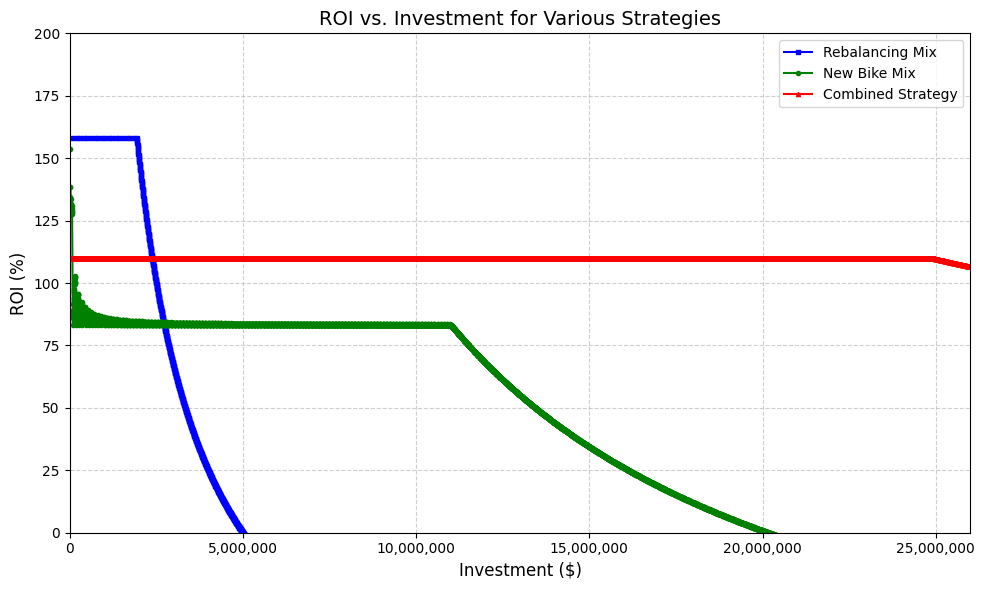

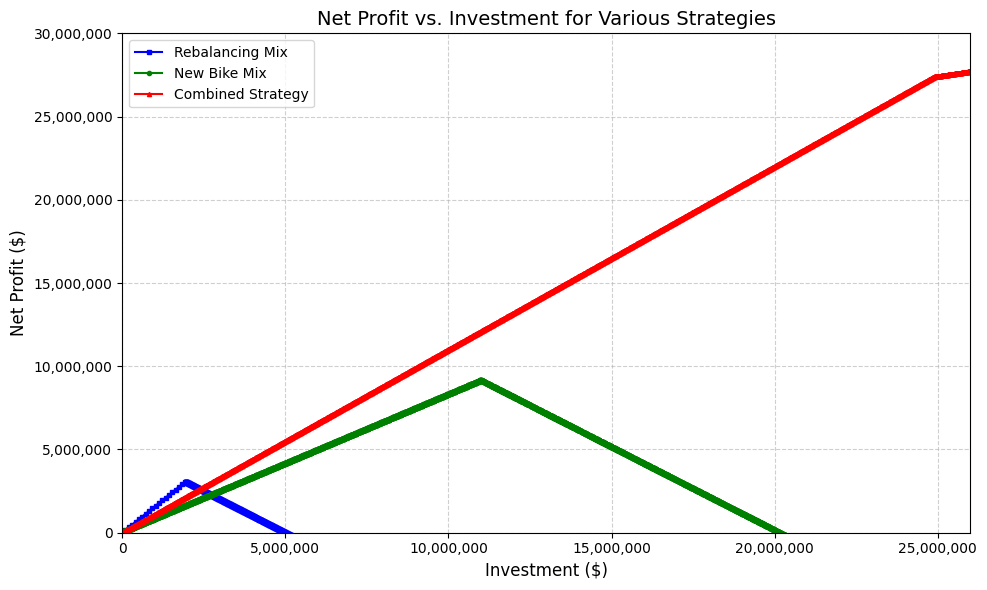

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

#############################################
# Common parameters for both strategies

# For buying bikes:
current_fleet = 6000
population = 3000000
saturation_fleet = 3*(population/1000)  # 9,000

# Revenue per ride
avg_rev_per_ride = 3.50

# Infrastructure cost parameters (for buying bikes)
docks_per_bike = 0.8
cost_dock = 1000
docks_per_station = 20
cost_station = 15000
labor_per_station = 3000

#############################################
# Trend A – New Bike Mix Only
# Using "Mix" bike parameters: cost = 2150, rides_per_bike = 160
# When buying bikes only, the system is limited by saturation.
nb_range_A = np.arange(1, 300001)  # Maximum new bikes before saturation (9000-6000=3000)
invest_A = []
roi_A = []
netprofit_A = []
for nb in nb_range_A:
    total_fleet = current_fleet + nb
    # Apply saturation: if fleet exceeds saturation, only (saturation - current_fleet) bikes are productive.
    if total_fleet <= saturation_fleet:
        monthly_new_rides = nb * 160
    else:
        productive_bikes = max(0, saturation_fleet - current_fleet)
        monthly_new_rides = productive_bikes * 160
    annual_new_rides = monthly_new_rides * 12
    annual_revenue = annual_new_rides * avg_rev_per_ride
    # Capital cost computations:
    new_docks = np.floor(nb * docks_per_bike)
    new_stations = np.floor(new_docks / docks_per_station)
    cost_bikes_capex = nb * 2150
    cost_docks_capex = new_docks * cost_dock
    cost_stations_capex = new_stations * cost_station
    cost_labor_capex = new_stations * labor_per_station
    total_capex = cost_bikes_capex + cost_docks_capex + cost_stations_capex + cost_labor_capex
    inv = total_capex
    profit = annual_revenue - inv
    r = (profit / inv * 100) if inv > 0 else 0
    invest_A.append(inv)
    netprofit_A.append(profit)
    roi_A.append(r)

#############################################
# Trend B – Rebalancing Mix Only
# Using rebalancing mix parameters: capacity = 4850 moves/month,
# cost = 36500, life = 6.8, operating cost per move = 1.67, revenue per move = 1.3*3.50 = 4.55.
capacity_rb = 4850
cost_rb = 36500
life_rb = 6.8
om_cost_rb = 1.67
rev_per_move = 1.3 * 3.50  # 4.55
max_moves = 91629  # limitation of imbalance events
rb_range = np.arange(1, 4001)  # range of rebalancing vehicles
invest_B = []
roi_B = []
netprofit_B = []
for rb in rb_range:
    total_capacity_rb = rb * capacity_rb
    effective_moves = min(total_capacity_rb, max_moves)
    annual_revenue_rb = effective_moves * rev_per_move * 12
    capital_cost_rb = rb * (cost_rb / life_rb)
    operating_cost_rb = effective_moves * om_cost_rb * 12
    inv_rb = capital_cost_rb + operating_cost_rb
    profit_rb = annual_revenue_rb - inv_rb
    r_rb = (profit_rb / inv_rb * 100) if inv_rb > 0 else 0
    invest_B.append(inv_rb)
    netprofit_B.append(profit_rb)
    roi_B.append(r_rb)

#############################################
# Trend C – Combined Strategy (New Bikes + Rebalancing)
# We assume a fixed 50-50 split (by investment).
# For the new bikes part, we assume that due to rebalancing the saturation limitation is overcome.
# So, monthly new rides = nb * 160 (no cap).
# However, now we enforce the saturation limit in the new-bike component:
#    total_fleet = current_fleet + nb
#    if total_fleet <= saturation_fleet:
#        monthly_new_rides = nb * 160
#    else:
#        productive_bikes = max(0, saturation_fleet - current_fleet)
#        monthly_new_rides = productive_bikes * 160
# For new bike part:
#   Investment_new ≈ nb * 4150. (Approximation from infrastructure costs)
# For rebalancing part (combined):
#   We use rebalancing mix parameters without a cap (i.e. effective moves = rb * capacity_rb)
#   Investment_rb ≈ rb * [ (36500/6.8) + (capacity_rb * om_cost_rb *12) ].
bike_cost_per_unit = 4150.0
rebalancing_unit_cost = (cost_rb / life_rb) + (capacity_rb * om_cost_rb * 12)  # no cap version
# Determine ratio such that Investment_new = Investment_rb:
r_ratio = bike_cost_per_unit / rebalancing_unit_cost  # rb = r_ratio * nb
# For a given nb, we define rb = nb * r_ratio.
nb_range_C = np.arange(1, 300001)
invest_C = []
roi_C = []
netprofit_C = []
for nb in nb_range_C:
    rb = nb * r_ratio
    total_fleet = current_fleet + nb
    # Enforce saturation on the new bike portion:
    if total_fleet <= saturation_fleet:
        monthly_new_rides_new = nb * 160
    else:
        productive_bikes = max(0, saturation_fleet - current_fleet)
        monthly_new_rides_new = productive_bikes * 160
    revenue_new = monthly_new_rides_new * 12 * avg_rev_per_ride  # new bikes revenue
    cost_new = nb * bike_cost_per_unit
    # Rebalancing part:
    revenue_rb = rb * capacity_rb * 12 * rev_per_move  # full revenue, no cap
    cost_rb_comb = rb * (cost_rb / life_rb) + rb * capacity_rb * om_cost_rb * 12
    inv_new = cost_new
    inv_rb = cost_rb_comb
    inv_comb = inv_new + inv_rb
    tot_revenue = revenue_new + revenue_rb
    profit_comb = tot_revenue - inv_comb
    r_comb = (profit_comb / inv_comb * 100) if inv_comb > 0 else 0
    invest_C.append(inv_comb)
    netprofit_C.append(profit_comb)
    roi_C.append(r_comb)

#############################################
# Plotting: Two diagrams with three curves each:
# 1. ROI vs. Investment.
# 2. Net Profit vs. Investment.
# All Investment values are from the appropriate strategy (Trend A from new-bike analysis,
# Trend B from rebalancing analysis, Trend C from combined).
# The x-axis (Investment) is limited to 150,000 and formatted with comma separators.

plt.figure(figsize=(10,6))
plt.plot(invest_B, roi_B, label="Rebalancing Mix", color="blue", marker="s", linestyle="-", markersize=3)
plt.plot(invest_A, roi_A, label="New Bike Mix", color="green", marker="o", linestyle="-", markersize=3)
plt.plot(invest_C, roi_C, label="Combined Strategy", color="red", marker="^", linestyle="-", markersize=3)
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("ROI (%)", fontsize=12)
plt.title("ROI vs. Investment for Various Strategies", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,26000000)
plt.ylim(0,200)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(invest_B, netprofit_B, label="Rebalancing Mix", color="blue", marker="s", linestyle="-", markersize=3)
plt.plot(invest_A, netprofit_A, label="New Bike Mix", color="green", marker="o", linestyle="-", markersize=3)
plt.plot(invest_C, netprofit_C, label="Combined Strategy", color="red", marker="^", linestyle="-", markersize=3)
plt.xlabel("Investment ($)", fontsize=12)
plt.ylabel("Net Profit ($)", fontsize=12)
plt.title("Net Profit vs. Investment for Various Strategies", fontsize=14)
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,26000000)
plt.ylim(0,30000000)
plt.tight_layout()
plt.show()